##Install Dependencies

In [1]:
!pip install transformers

In [2]:
!pip install pytextrank

In [3]:
!python -m spacy download en_core_web_lg

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 400.7/400.7 MB 1.9 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_lg')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


In [4]:
!pip install plotly

In [5]:
!pip install kaleido
!pip install -U kaleido

## Import Packages

In [15]:
import re
import os
import json
import torch
import spacy
import pytextrank
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.graph_objects as go
from tqdm.notebook import tqdm
from collections import Counter
from collections import defaultdict
from transformers import pipeline
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, mean_absolute_error, confusion_matrix
from sklearn.preprocessing import LabelEncoder
from sklearn.utils import resample
from imblearn.over_sampling import SMOTE
from sklearn.feature_extraction.text import TfidfVectorizer

/usr/local/lib/python3.12/dist-packages


In [7]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [8]:
df_real = pd.read_csv('/content/drive/MyDrive/DatasetForColab/Zeroshot1/true.csv')
df_fake = pd.read_csv('/content/drive/MyDrive/DatasetForColab/Zeroshot1/fake.csv')

In [9]:
df_real.head()

,title,text,subject,date
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,politicsNews,"December 31, 2017"
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,politicsNews,"December 29, 2017"
2,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,politicsNews,"December 31, 2017"
3,FBI Russia probe helped by Australian diplomat...,WASHINGTON (Reuters) - Trump campaign adviser ...,politicsNews,"December 30, 2017"
4,Trump wants Postal Service to charge 'much mor...,SEATTLE/WASHINGTON (Reuters) - President Donal...,politicsNews,"December 29, 2017"


In [10]:
df_fake.head()

,title,text,subject,date
0,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump just couldn t wish all Americans ...,News,"December 31, 2017"
1,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...,News,"December 31, 2017"
2,Sheriff David Clarke Becomes An Internet Joke...,"On Friday, it was revealed that former Milwauk...",News,"December 30, 2017"
3,Trump Is So Obsessed He Even Has Obama’s Name...,"On Christmas day, Donald Trump announced that ...",News,"December 29, 2017"
4,Pope Francis Just Called Out Donald Trump Dur...,Pope Francis used his annual Christmas Day mes...,News,"December 25, 2017"


## Combine Both Dataset

In [11]:
df_real['label'] = 'real'
df_fake['label'] = 'fake'

# Step 3: Combine both DataFrames
df = pd.concat([df_real, df_fake], ignore_index=True)

# Step 4: Shuffle the data
df = df.sample(frac=1, random_state=42).reset_index(drop=True)

# Optional: Check balance
print(df['label'].value_counts())




label
fake    23481
real    21417
Name: count, dtype: int64


In [12]:
df.head()

,title,text,subject,date,label
0,BREAKING: GOP Chairman Grassley Has Had Enoug...,"Donald Trump s White House is in chaos, and th...",News,"July 21, 2017",fake
1,Failed GOP Candidates Remembered In Hilarious...,Now that Donald Trump is the presumptive GOP n...,News,"May 7, 2016",fake
2,Mike Pence’s New DC Neighbors Are HILARIOUSLY...,Mike Pence is a huge homophobe. He supports ex...,News,"December 3, 2016",fake
3,California AG pledges to defend birth control ...,SAN FRANCISCO (Reuters) - California Attorney ...,politicsNews,"October 6, 2017",real
4,AZ RANCHERS Living On US-Mexico Border Destroy...,Twisted reasoning is all that comes from Pelos...,politics,"Apr 25, 2017",fake


In [13]:
df.columns

Index(['title', 'text', 'subject', 'date', 'label'], dtype='object')

##Summarize the dataset

In [16]:

nlp = spacy.load("en_core_web_lg")
nlp.add_pipe("textrank")

def summarize_text(text, limit_phrases=2, limit_sentences=2):
    if not isinstance(text, str) or text.strip() == "":
        return ""
    try:
        doc = nlp(text)
        summary_sents = [sent.text for sent in doc._.textrank.summary(limit_phrases=limit_phrases, limit_sentences=limit_sentences)]
        summary = ' '.join(summary_sents)
        return summary
    except Exception as e:
        print(f"Error summarizing text: {e}")
        return ""

save_path = '/content/drive/MyDrive/DatasetForColab/Zeroshot1/df_with_summary.json'

# Load existing results if available, else create empty DataFrame
if os.path.exists(save_path):
    df_results = pd.read_json(save_path, lines=True)
    start_index = len(df_results)
    print(f"Resuming from row {start_index}")
else:
    df_results = pd.DataFrame(columns=list(df.columns) + ['summary'])
    start_index = 0

for i in tqdm(range(start_index, len(df))):
    row = df.iloc[i]
    summary = summarize_text(row['text'])
    new_row = row.to_dict()
    new_row['summary'] = summary

    df_results = pd.concat([df_results, pd.DataFrame([new_row])], ignore_index=True)

    if (i + 1) % 2000 == 0 or (i + 1) == len(df):
        df_results.to_json(save_path, orient='records', lines=True)
        print(f"Saved progress at row {i + 1}")

print("Summarization complete!")

Resuming from row 44898


0it [00:00, ?it/s]

Summarization complete!


In [17]:
df_results.head()

,title,text,subject,date,label,summary
0,BREAKING: GOP Chairman Grassley Has Had Enoug...,"Donald Trump s White House is in chaos, and th...",News,"July 21, 2017",fake,"Donald Trump s White House is in chaos, and th..."
1,Failed GOP Candidates Remembered In Hilarious...,Now that Donald Trump is the presumptive GOP n...,News,"May 7, 2016",fake,"After all, how can we forget all the missteps,..."
2,Mike Pence’s New DC Neighbors Are HILARIOUSLY...,Mike Pence is a huge homophobe. He supports ex...,News,"December 3, 2016",fake,@NewsChannel8 @ABC7News #LGBTQ #LGBT pic.twitt...
3,California AG pledges to defend birth control ...,SAN FRANCISCO (Reuters) - California Attorney ...,politicsNews,"October 6, 2017",real,Becerra and other Democratic attorneys general...
4,AZ RANCHERS Living On US-Mexico Border Destroy...,Twisted reasoning is all that comes from Pelos...,politics,"Apr 25, 2017",fake,While laughing at claims made by Democrat Hous...


## Preprocess the dataset

In [18]:
# --- Step 1: Preprocessing ---
def preprocess_text_dataset(df, text_column='text', new_column='clean_text'):
    def clean_text(text):
        text = str(text) if not pd.isnull(text) else ""
        text = re.sub(r'[^a-zA-Z0-9\s]', '', text)  # Remove punctuation/special chars
        text = text.lower()
        text = re.sub(r'\s+', ' ', text).strip()
        return text

    df[new_column] = df[text_column].apply(clean_text)
    return df

In [19]:
df = preprocess_text_dataset(df_results, text_column='summary', new_column='clean_text')

In [20]:
df.head()

,title,text,subject,date,label,summary,clean_text
0,BREAKING: GOP Chairman Grassley Has Had Enoug...,"Donald Trump s White House is in chaos, and th...",News,"July 21, 2017",fake,"Donald Trump s White House is in chaos, and th...",donald trump s white house is in chaos and the...
1,Failed GOP Candidates Remembered In Hilarious...,Now that Donald Trump is the presumptive GOP n...,News,"May 7, 2016",fake,"After all, how can we forget all the missteps,...",after all how can we forget all the missteps g...
2,Mike Pence’s New DC Neighbors Are HILARIOUSLY...,Mike Pence is a huge homophobe. He supports ex...,News,"December 3, 2016",fake,@NewsChannel8 @ABC7News #LGBTQ #LGBT pic.twitt...,newschannel8 abc7news lgbtq lgbt pictwittercom...
3,California AG pledges to defend birth control ...,SAN FRANCISCO (Reuters) - California Attorney ...,politicsNews,"October 6, 2017",real,Becerra and other Democratic attorneys general...,becerra and other democratic attorneys general...
4,AZ RANCHERS Living On US-Mexico Border Destroy...,Twisted reasoning is all that comes from Pelos...,politics,"Apr 25, 2017",fake,While laughing at claims made by Democrat Hous...,while laughing at claims made by democrat hous...


In [21]:
df.head()
print(df['label'].value_counts())


label
fake    23481
real    21417
Name: count, dtype: int64


## Removing empty rows

In [22]:

# Check label distribution before removing
print("Before cleaning:")
print(df["label"].value_counts())

# -------------------------------
# Remove rows with ANY empty column
# -------------------------------
# Step 1: Replace empty strings with NaN
df.replace("", pd.NA, inplace=True)

# Step 2: Drop rows with any NaN values
df.dropna(inplace=True)

# Step 3: Reset index after dropping
df = df.reset_index(drop=True)

# -------------------------------
# Final checks
# -------------------------------
print("\nAfter cleaning:")
print(df["label"].value_counts())
print("Final shape:", df.shape)

Before cleaning:
label
fake    23481
real    21417
Name: count, dtype: int64

After cleaning:
label
fake    22851
real    21416
Name: count, dtype: int64
Final shape: (44267, 7)


## Balance the dataset

In [23]:

# Check label distribution before downsampling
print("Before downsampling:")
print(df['label'].value_counts())

# Separate majority and minority classes
majority_class = df['label'].value_counts().idxmax()
minority_class = df['label'].value_counts().idxmin()

df_majority = df[df['label'] == majority_class]
df_minority = df[df['label'] == minority_class]

# Downsample majority class to minority class size
df_majority_downsampled = resample(
    df_majority,
    replace=False,               # sample without replacement
    n_samples=len(df_minority),  # match minority size
    random_state=42              # reproducible results
)

# Combine downsampled majority class with minority class
df_balanced = pd.concat([df_majority_downsampled, df_minority])

# Shuffle the balanced dataframe
df_balanced = df_balanced.sample(frac=1, random_state=42).reset_index(drop=True)

# Check the new label distribution
print("\nAfter downsampling and balancing:")
print(df_balanced['label'].value_counts())
print("Balanced shape:", df_balanced.shape)

Before downsampling:
label
fake    22851
real    21416
Name: count, dtype: int64

After downsampling and balancing:
label
fake    21416
real    21416
Name: count, dtype: int64
Balanced shape: (42832, 7)


In [24]:
df_balanced.columns

Index(['title', 'text', 'subject', 'date', 'label', 'summary', 'clean_text'], dtype='object')

In [25]:
df_balanced.head()

,title,text,subject,date,label,summary,clean_text
0,NEW DOCUMENTS: Hillary And State Department Ai...,Hillary Clinton and her aides must have felt l...,Government News,"Aug 19, 2016",fake,The RNC press release reads in part:While the ...,the rnc press release reads in partwhile the s...
1,LEFTIST PROF WHO WANTS “Earth Constitution” Wi...,Why would the Vatican invite an aggressive lef...,Government News,"Jun 13, 2015",fake,Climate skeptics have already started criticiz...,climate skeptics have already started criticiz...
2,WATCH: Jon Stewart Joins Colbert To HUMILIATE...,As Donald Trump continues to issue executive o...,News,"February 1, 2017",fake,As Donald Trump continues to issue executive o...,as donald trump continues to issue executive o...
3,Trump denies trying to get security clearance ...,WASHINGTON (Reuters) - Republican President-el...,politicsNews,"November 16, 2016",real,WASHINGTON (Reuters) - Republican President-el...,washington reuters republican presidentelect d...
4,BREAKING: [AUDIO] CHILLING 911 CALL THREATENS ...,"We re not gonna go away, we re not gonna quit...",left-news,"Sep 8, 2015",fake,"Approximately four hours later, Aurora police ...",approximately four hours later aurora police o...


## MoritzLaurer/DeBERTa-v3-large-mnli-fever-anli-ling-wanli


In [26]:
# === Config ===
MODEL_NAME = "MoritzLaurer/DeBERTa-v3-large-mnli-fever-anli-ling-wanli"
SAVE_PATH = "/content/drive/MyDrive/DatasetForColab/Zeroshot1/Deberta_maxscore_results(0.8).json"
THRESHOLD = 0.8
LABELS = [
    "This news is real and based on facts.",
    "This news is fake and contains misinformation."
]

# === Load model and tokenizer ===
classifier = pipeline("zero-shot-classification", model=MODEL_NAME, device=0)
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)

# === Load your dataset ===
df_balanced = df_balanced.copy()
texts = df_balanced["clean_text"].tolist()
true_labels = df_balanced["label"].tolist()

# === Chunking function ===
def chunk_text(text, tokenizer, max_tokens=512):
    tokens = tokenizer.tokenize(text)
    chunks = []
    for i in range(0, len(tokens), max_tokens):
        chunk = tokenizer.convert_tokens_to_string(tokens[i:i + max_tokens])
        chunks.append(chunk)
    return chunks

# === Classifier function ===
def classify_with_max_chunk(text, tokenizer, classifier, labels, threshold=0.8):
    chunks = chunk_text(text, tokenizer)
    score_dict = defaultdict(float)

    for chunk in chunks:
        result = classifier(chunk, candidate_labels=labels)
        for label, score in zip(result["labels"], result["scores"]):
            score_dict[label] = max(score_dict[label], score)

    final_label = max(score_dict, key=score_dict.get)
    final_score = score_dict[final_label]

    if final_score >= threshold:
        return final_label, final_score
    else:
        return "uncertain", final_score

# === Load saved progress ===
try:
    with open(SAVE_PATH, 'r') as f:
        saved_results = json.load(f)
    print(f"✅ Loaded {len(saved_results)} saved results.")
except FileNotFoundError:
    saved_results = []
    print("🆕 No saved results found. Starting fresh.")

start_index = len(saved_results)

# === Run classification ===
for i in tqdm(range(start_index, len(texts)), desc="Classifying"):
    text = texts[i]
    true_label = true_labels[i]

    predicted_label, score = classify_with_max_chunk(
        text, tokenizer, classifier, LABELS, threshold=THRESHOLD
    )

    saved_results.append({
        "index": i,
        "text": text,
        "true_label": true_label,
        "predicted_label": predicted_label,
        "confidence": round(score, 4)
    })
  # Save every 2000 rows or at the very end
    if (i + 1) % 2000 == 0 or (i + 1) == len(texts):
        with open(SAVE_PATH, 'w') as f:
            json.dump(saved_results, f, indent=2)
        print(f"💾 Saved progress at {i + 1} rows.")

print(f"✅ Classification complete. {len(saved_results)} articles processed and saved to JSON.")

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json: 0.00B [00:00, ?B/s]

model.safetensors:   0%|          | 0.00/870M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/395 [00:00<?, ?B/s]

spm.model:   0%|          | 0.00/2.46M [00:00<?, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

added_tokens.json:   0%|          | 0.00/18.0 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/156 [00:00<?, ?B/s]

Device set to use cpu


✅ Loaded 42832 saved results.


Classifying: 0it [00:00, ?it/s]

✅ Classification complete. 42832 articles processed and saved to JSON.


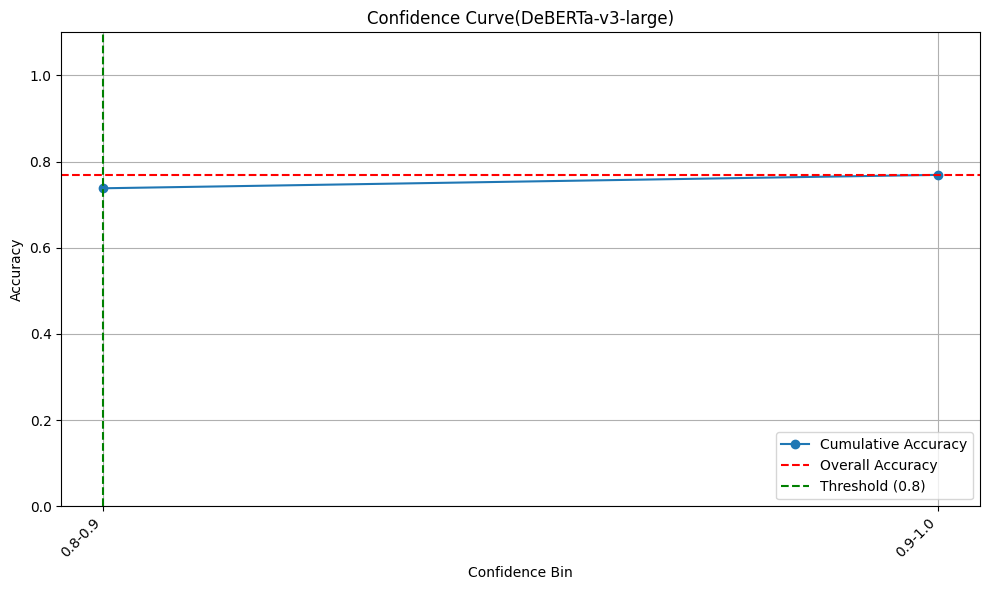


Confidence Data:
  confidence_bin  count  accuracy  cumulative_count  cumulative_accuracy
0        0.8-0.9  10158  0.738039             10158             0.738039
1        0.9-1.0   7232  0.812915             17390             0.769178


In [27]:
# Define threshold
THRESHOLD = 0.8

# Convert results to DataFrame
df_results = pd.DataFrame(saved_results)

# Map predicted labels to 'real', 'fake', or 'uncertain'
label_mapping = {
    "This news is real and based on facts.": "real",
    "This news is fake and contains misinformation.": "fake"
}
df_results['predicted_label_mapped'] = df_results['predicted_label'].map(label_mapping).fillna('uncertain')

# Filter out 'uncertain' predictions
df_filtered = df_results[df_results['predicted_label_mapped'] != 'uncertain'].copy()
df_filtered['is_correct'] = (df_filtered['true_label'] == df_filtered['predicted_label_mapped'])

# Bin confidence scores
bins = np.arange(0, 1.01, 0.1)
bin_labels = [f'{b:.1f}-{b + 0.1:.1f}' for b in bins[:-1]]  # ← fixed here
df_filtered['confidence_bin'] = pd.cut(df_filtered['confidence'], bins=bins, right=False, labels=bin_labels)


# Calculate accuracy per bin (⚠️ fixed warning by adding observed=True)
confidence_accuracy = df_filtered.groupby('confidence_bin', observed=True)['is_correct'].mean().reset_index()
confidence_accuracy = confidence_accuracy.rename(columns={'is_correct': 'accuracy'})

# Count samples in each bin (⚠️ fixed warning by adding observed=True)
bin_counts = df_filtered.groupby('confidence_bin', observed=True).size().reset_index(name='count')

# Merge data
confidence_data = pd.merge(confidence_accuracy, bin_counts, on='confidence_bin')

# Calculate cumulative values
confidence_data['bin_midpoint'] = confidence_data['confidence_bin'].apply(lambda x: float(x.split('-')[0]) + 0.05 if pd.notna(x) else np.nan)
confidence_data = confidence_data.sort_values('bin_midpoint').reset_index(drop=True)
confidence_data['cumulative_count'] = confidence_data['count'].cumsum()
confidence_data['cumulative_correct'] = (confidence_data['accuracy'] * confidence_data['count']).cumsum()
confidence_data['cumulative_accuracy'] = confidence_data['cumulative_correct'] / confidence_data['cumulative_count']

# Drop midpoint if not needed
confidence_data = confidence_data.drop(columns=['bin_midpoint'])

# Drop empty bins
confidence_data = confidence_data.dropna(subset=['cumulative_accuracy'])

# Plot
plt.figure(figsize=(10, 6))
plt.plot(confidence_data['confidence_bin'], confidence_data['cumulative_accuracy'], marker='o', linestyle='-', label='Cumulative Accuracy')

# Add horizontal line for overall accuracy
overall_accuracy = df_filtered['is_correct'].mean()
plt.axhline(y=overall_accuracy, color='r', linestyle='--', label='Overall Accuracy')

# Add vertical line for threshold bin
threshold_bin = f'{THRESHOLD:.1f}-{THRESHOLD + 0.1:.1f}'
if threshold_bin in confidence_data['confidence_bin'].values:
    plt.axvline(x=threshold_bin, color='g', linestyle='--', label=f'Threshold ({THRESHOLD:.1f})')

# Format plot
plt.xlabel('Confidence Bin')
plt.ylabel('Accuracy')
plt.title('Confidence Curve(DeBERTa-v3-large)')
plt.grid(True)
plt.xticks(rotation=45, ha='right')
plt.ylim(0, 1.1)
plt.legend(loc='lower right')
plt.tight_layout()
plt.savefig('confidence_curve(DeBERTa-v3-large).png')
plt.show()


# Optional: Print the data table
print("\nConfidence Data:")
print(confidence_data[['confidence_bin', 'count', 'accuracy', 'cumulative_count', 'cumulative_accuracy']])

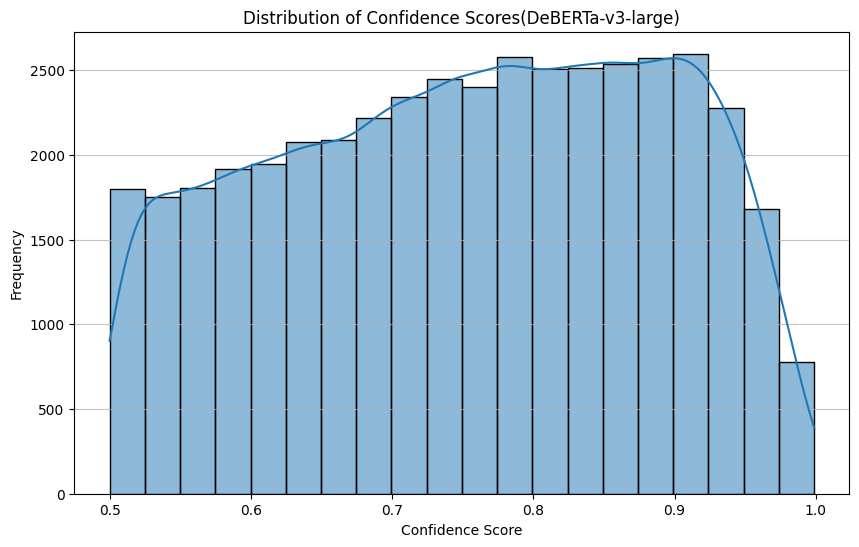


Confidence Score Statistics:
count    42832.000000
mean         0.752651
std          0.133596
min          0.500000
25%          0.642775
50%          0.760200
75%          0.865800
max          0.998900
Name: confidence, dtype: float64


In [28]:
# prompt: distribution of confidence scores across all predictions.

# Plotting the distribution of confidence scores
plt.figure(figsize=(10, 6))
sns.histplot(df_results['confidence'], bins=20, kde=True)
plt.title('Distribution of Confidence Scores(DeBERTa-v3-large)')
plt.xlabel('Confidence Score')
plt.ylabel('Frequency')
plt.grid(axis='y', alpha=0.75)
plt.savefig('confidence_score_distribution(DeBERTa-v3-large).png')
plt.show()

# Optional: Basic statistics of confidence scores
print("\nConfidence Score Statistics:")
print(df_results['confidence'].describe())

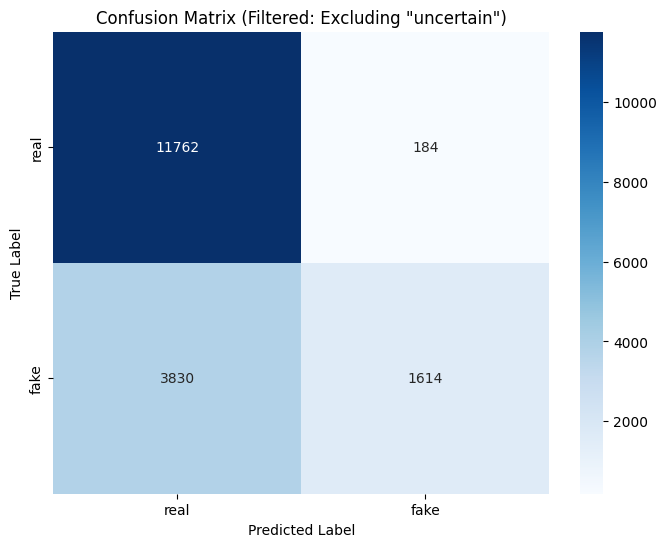


Confusion Matrix:
[[11762   184]
 [ 3830  1614]]


In [29]:
# prompt: confusion matrix for th eabove model

# Get true and predicted labels from the filtered DataFrame
true_labels_filtered = df_filtered['true_label']
predicted_labels_filtered = df_filtered['predicted_label_mapped']

# Generate the confusion matrix
cm = confusion_matrix(true_labels_filtered, predicted_labels_filtered, labels=['real', 'fake'])

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['real', 'fake'], yticklabels=['real', 'fake'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix (Filtered: Excluding "uncertain")')
plt.savefig('confusion_matrix_filtered(DeBERTa-v3-large).png')
plt.show()

# Optional: Calculate and print confusion matrix values
print("\nConfusion Matrix:")
print(cm)

##facebook/bart-large-mnli

In [30]:
# === Config ===
MODEL_NAME = "facebook/bart-large-mnli"
SAVE_PATH = "/content/drive/MyDrive/DatasetForColab/Zeroshot1/bart_maxscore_results(0.8).json"
THRESHOLD = 0.8
LABELS = [
    "This news is real and based on facts.",
    "This news is fake and contains misinformation."
]

# === Load model and tokenizer ===
classifier = pipeline("zero-shot-classification", model=MODEL_NAME, device=0)
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)

# === Load your dataset ===
df_balanced = df_balanced.copy()
texts = df_balanced["clean_text"].tolist()
true_labels = df_balanced["label"].tolist()

# === Chunking function ===
def chunk_text(text, tokenizer, max_tokens=512):
    tokens = tokenizer.tokenize(text)
    chunks = []
    for i in range(0, len(tokens), max_tokens):
        chunk = tokenizer.convert_tokens_to_string(tokens[i:i + max_tokens])
        chunks.append(chunk)
    return chunks

# === Classifier function ===
def classify_with_max_chunk(text, tokenizer, classifier, labels, threshold=0.8):
    chunks = chunk_text(text, tokenizer)
    score_dict = defaultdict(float)

    for chunk in chunks:
        result = classifier(chunk, candidate_labels=labels)
        for label, score in zip(result["labels"], result["scores"]):
            score_dict[label] = max(score_dict[label], score)

    final_label = max(score_dict, key=score_dict.get)
    final_score = score_dict[final_label]

    if final_score >= threshold:
        return final_label, final_score
    else:
        return "uncertain", final_score

# === Load saved progress ===
try:
    with open(SAVE_PATH, 'r') as f:
        saved_results = json.load(f)
    print(f"✅ Loaded {len(saved_results)} saved results.")
except FileNotFoundError:
    saved_results = []
    print("🆕 No saved results found. Starting fresh.")

start_index = len(saved_results)

# === Run classification ===
for i in tqdm(range(start_index, len(texts)), desc="Classifying"):
    text = texts[i]
    true_label = true_labels[i]

    predicted_label, score = classify_with_max_chunk(
        text, tokenizer, classifier, LABELS, threshold=THRESHOLD
    )

    saved_results.append({
        "index": i,
        "text": text,
        "true_label": true_label,
        "predicted_label": predicted_label,
        "confidence": round(score, 4)
    })
  # Save every 2000 rows or at the very end
    if (i + 1) % 2000 == 0 or (i + 1) == len(texts):
        with open(SAVE_PATH, 'w') as f:
            json.dump(saved_results, f, indent=2)
        print(f"💾 Saved progress at {i + 1} rows.")

print(f"✅ Classification complete. {len(saved_results)} articles processed and saved to JSON.")


config.json: 0.00B [00:00, ?B/s]

model.safetensors:   0%|          | 0.00/1.63G [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

Device set to use cpu


✅ Loaded 42832 saved results.


Classifying: 0it [00:00, ?it/s]

✅ Classification complete. 42832 articles processed and saved to JSON.


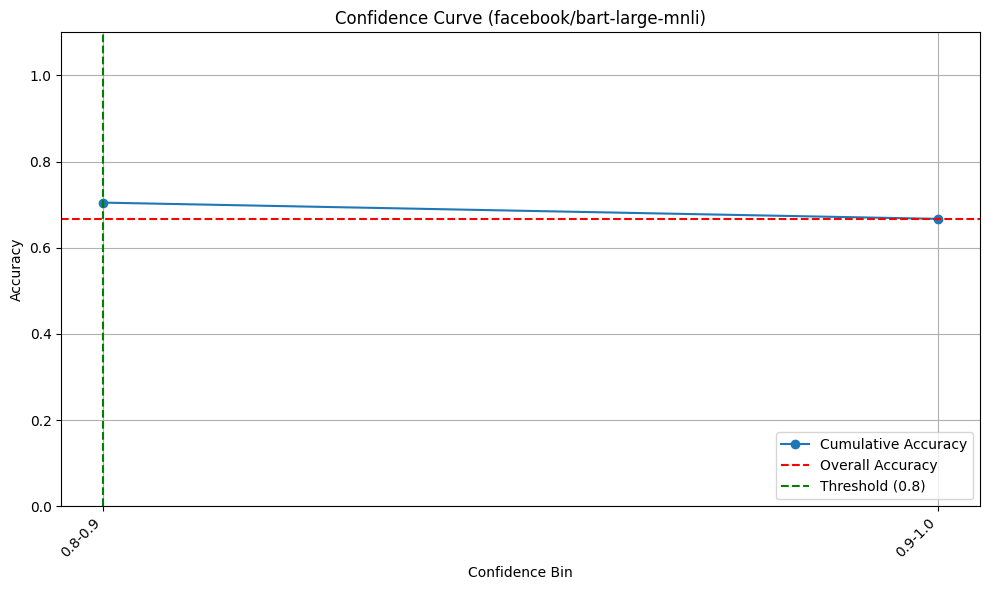


Confidence Data:
  confidence_bin  count  accuracy  cumulative_count  cumulative_accuracy
0        0.8-0.9  13657  0.704767             13657             0.704767
1        0.9-1.0  10231  0.616655             23888             0.667029


In [31]:
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# === Config ===
SAVE_PATH = "/content/drive/MyDrive/DatasetForColab/Zeroshot1/bart_maxscore_results(0.8).json"
THRESHOLD = 0.8

# === Load JSON (array format) ===
with open(SAVE_PATH, "r") as f:
    saved_results = json.load(f)

# === Convert to DataFrame ===
df_results = pd.DataFrame(saved_results)

# === Label Mapping ===
label_mapping = {
    "This news is real and based on facts.": "real",
    "This news is fake and contains misinformation.": "fake"
}
df_results['predicted_label_mapped'] = df_results['predicted_label'].map(label_mapping).fillna('uncertain')

# === Filter out uncertain predictions ===
df_filtered = df_results[df_results['predicted_label_mapped'] != 'uncertain'].copy()
df_filtered['is_correct'] = (df_filtered['true_label'] == df_filtered['predicted_label_mapped'])

# === Bin confidence scores ===
bins = np.arange(0, 1.01, 0.1)
bin_labels = [f'{b:.1f}-{b + 0.1:.1f}' for b in bins[:-1]]
df_filtered['confidence_bin'] = pd.cut(df_filtered['confidence'], bins=bins, right=False, labels=bin_labels)

# === Accuracy per bin ===
confidence_accuracy = df_filtered.groupby('confidence_bin', observed=True)['is_correct'].mean().reset_index()
confidence_accuracy = confidence_accuracy.rename(columns={'is_correct': 'accuracy'})

# === Count per bin ===
bin_counts = df_filtered.groupby('confidence_bin', observed=True).size().reset_index(name='count')

# === Merge accuracy + counts ===
confidence_data = pd.merge(confidence_accuracy, bin_counts, on='confidence_bin')

# === Cumulative calculations ===
confidence_data['bin_midpoint'] = confidence_data['confidence_bin'].apply(
    lambda x: float(x.split('-')[0]) + 0.05 if pd.notna(x) else np.nan
)
confidence_data = confidence_data.sort_values('bin_midpoint').reset_index(drop=True)
confidence_data['cumulative_count'] = confidence_data['count'].cumsum()
confidence_data['cumulative_correct'] = (confidence_data['accuracy'] * confidence_data['count']).cumsum()
confidence_data['cumulative_accuracy'] = confidence_data['cumulative_correct'] / confidence_data['cumulative_count']

# === Clean up and drop bins with no accuracy ===
confidence_data = confidence_data.drop(columns=['bin_midpoint'])
confidence_data = confidence_data.dropna(subset=['cumulative_accuracy'])

# === Plot ===
plt.figure(figsize=(10, 6))
plt.plot(confidence_data['confidence_bin'], confidence_data['cumulative_accuracy'],
         marker='o', linestyle='-', label='Cumulative Accuracy')

# Horizontal line for overall accuracy
overall_accuracy = df_filtered['is_correct'].mean()
plt.axhline(y=overall_accuracy, color='r', linestyle='--', label='Overall Accuracy')

# Vertical line for threshold
threshold_bin = f'{THRESHOLD:.1f}-{THRESHOLD + 0.1:.1f}'
if threshold_bin in confidence_data['confidence_bin'].values:
    plt.axvline(x=threshold_bin, color='g', linestyle='--', label=f'Threshold ({THRESHOLD:.1f})')

# === Plot formatting ===
plt.xlabel('Confidence Bin')
plt.ylabel('Accuracy')
plt.title('Confidence Curve (facebook/bart-large-mnli)')
plt.grid(True)
plt.xticks(rotation=45, ha='right')
plt.ylim(0, 1.1)
plt.legend(loc='lower right')
plt.tight_layout()
plt.savefig('confidence_curve_bart.png')
plt.show()

# === Print table ===
print("\nConfidence Data:")
print(confidence_data[['confidence_bin', 'count', 'accuracy', 'cumulative_count', 'cumulative_accuracy']])


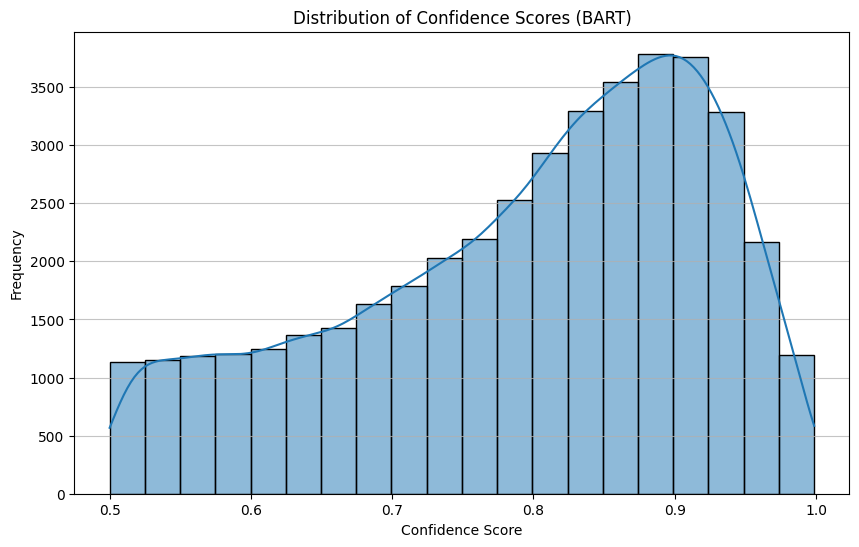

In [32]:
# prompt: distribusion of confidence score for bart mdel

# Plotting the distribution of confidence scores for the BART model
plt.figure(figsize=(10, 6))
sns.histplot(pd.DataFrame(saved_results)['confidence'], bins=20, kde=True)
plt.title('Distribution of Confidence Scores (BART)')
plt.xlabel('Confidence Score')
plt.ylabel('Frequency')
plt.grid(axis='y', alpha=0.75)
plt.savefig('confidence_score_distribution_bart.png')
plt.show()

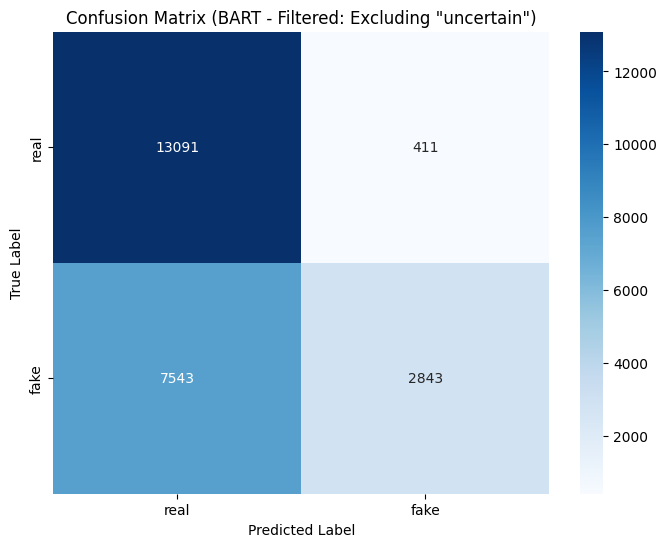


Confusion Matrix (BART):


array([[13091,   411],
       [ 7543,  2843]])

In [33]:
# prompt: only confusion matrix

# Convert results to DataFrame
df_results_bart = pd.DataFrame(saved_results)

# Map predicted labels to 'real', 'fake', or 'uncertain'
label_mapping = {
    "This news is real and based on facts.": "real",
    "This news is fake and contains misinformation."
: "fake"
}
df_results_bart['predicted_label_mapped'] = df_results_bart['predicted_label'].map(label_mapping).fillna('uncertain')

# Filter out 'uncertain' predictions
df_filtered_bart = df_results_bart[df_results_bart['predicted_label_mapped'] != 'uncertain'].copy()
df_filtered_bart['is_correct'] = (df_filtered_bart['true_label'] == df_filtered_bart['predicted_label_mapped'])

# Get true and predicted labels from the filtered DataFrame for BART
true_labels_filtered_bart = df_filtered_bart['true_label']
predicted_labels_filtered_bart = df_filtered_bart['predicted_label_mapped']

# Generate the confusion matrix for BART
cm_bart = confusion_matrix(true_labels_filtered_bart, predicted_labels_filtered_bart, labels=['real', 'fake'])

# Plot the confusion matrix for BART
plt.figure(figsize=(8, 6))
sns.heatmap(cm_bart, annot=True, fmt='d', cmap='Blues', xticklabels=['real', 'fake'], yticklabels=['real', 'fake'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix (BART - Filtered: Excluding "uncertain")')
plt.savefig('confusion_matrix_filtered_bart.png')
plt.show()

# Optional: Calculate and print confusion matrix values for BART
print("\nConfusion Matrix (BART):")
cm_bart

## MoritzLaurer/ModernBERT-large-zeroshot-v2.0

In [34]:
torch.set_float32_matmul_precision('high')  # Enables TF32-optimized matmul
import torch._dynamo
torch._dynamo.config.suppress_errors = True

In [35]:
# === Config ===
MODEL_NAME = "MoritzLaurer/ModernBERT-large-zeroshot-v2.0"
SAVE_PATH = "/content/drive/MyDrive/DatasetForColab/Zeroshot1/Modernbert_maxscore_results(0.8).json"
THRESHOLD = 0.8
LABELS = [
    "This news is real and based on facts.",
    "This news is fake and contains misinformation."
]

# === Load model and tokenizer ===
classifier = pipeline("zero-shot-classification", model=MODEL_NAME, device=0)
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)

# === Load your dataset ===
df_balanced = df_balanced.copy()
texts = df_balanced["clean_text"].tolist()
true_labels = df_balanced["label"].tolist()

# === Chunking function ===
def chunk_text(text, tokenizer, max_tokens=512):
    tokens = tokenizer.tokenize(text)
    chunks = []
    for i in range(0, len(tokens), max_tokens):
        chunk = tokenizer.convert_tokens_to_string(tokens[i:i + max_tokens])
        chunks.append(chunk)
    return chunks

# === Classifier function ===
def classify_with_max_chunk(text, tokenizer, classifier, labels, threshold=0.8):
    chunks = chunk_text(text, tokenizer)
    score_dict = defaultdict(float)

    for chunk in chunks:
        result = classifier(chunk, candidate_labels=labels)
        for label, score in zip(result["labels"], result["scores"]):
            score_dict[label] = max(score_dict[label], score)

    final_label = max(score_dict, key=score_dict.get)
    final_score = score_dict[final_label]

    if final_score >= threshold:
        return final_label, final_score
    else:
        return "uncertain", final_score

# === Load saved progress ===
try:
    with open(SAVE_PATH, 'r') as f:
        saved_results = json.load(f)
    print(f"✅ Loaded {len(saved_results)} saved results.")
except FileNotFoundError:
    saved_results = []
    print("🆕 No saved results found. Starting fresh.")

start_index = len(saved_results)

# === Run classification ===
for i in tqdm(range(start_index, len(texts)), desc="Classifying"):
    text = texts[i]
    true_label = true_labels[i]

    predicted_label, score = classify_with_max_chunk(
        text, tokenizer, classifier, LABELS, threshold=THRESHOLD
    )

    saved_results.append({
        "index": i,
        "text": text,
        "true_label": true_label,
        "predicted_label": predicted_label,
        "confidence": round(score, 4)
    })
  # Save every 2000 rows or at the very end
    if (i + 1) % 2000 == 0 or (i + 1) == len(texts):
        with open(SAVE_PATH, 'w') as f:
            json.dump(saved_results, f, indent=2)
        print(f"💾 Saved progress at {i + 1} rows.")

print(f"✅ Classification complete. {len(saved_results)} articles processed and saved to JSON.")


config.json: 0.00B [00:00, ?B/s]

model.safetensors:   0%|          | 0.00/792M [00:00<?, ?B/s]

tokenizer_config.json: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/694 [00:00<?, ?B/s]

Device set to use cpu


✅ Loaded 42832 saved results.


Classifying: 0it [00:00, ?it/s]

✅ Classification complete. 42832 articles processed and saved to JSON.


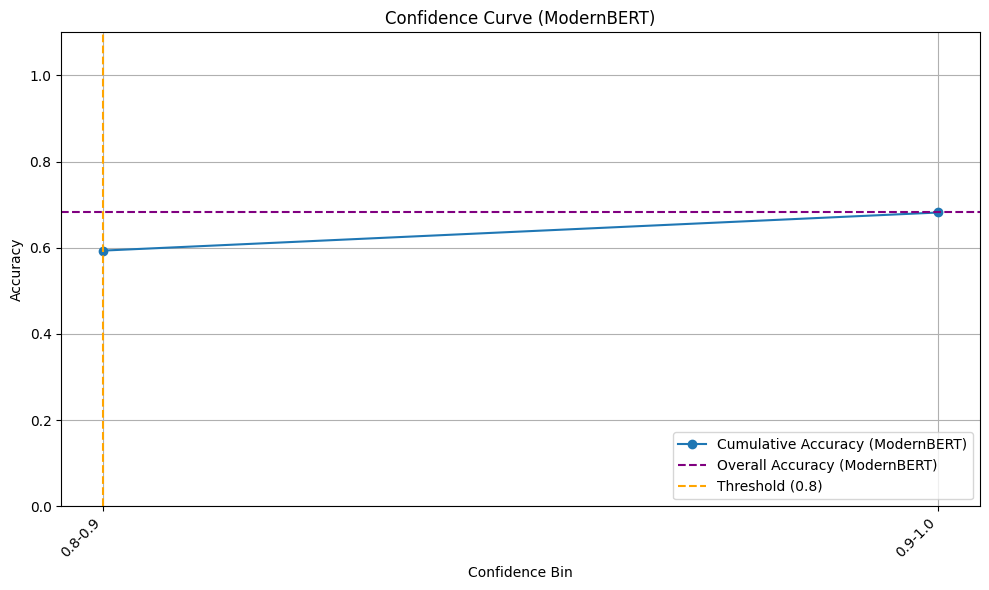


Confidence Data (ModernBERT):
  confidence_bin  count  accuracy  cumulative_count  cumulative_accuracy
0        0.8-0.9   9535  0.593393              9535             0.593393
1        0.9-1.0  19981  0.724038             29516             0.681834


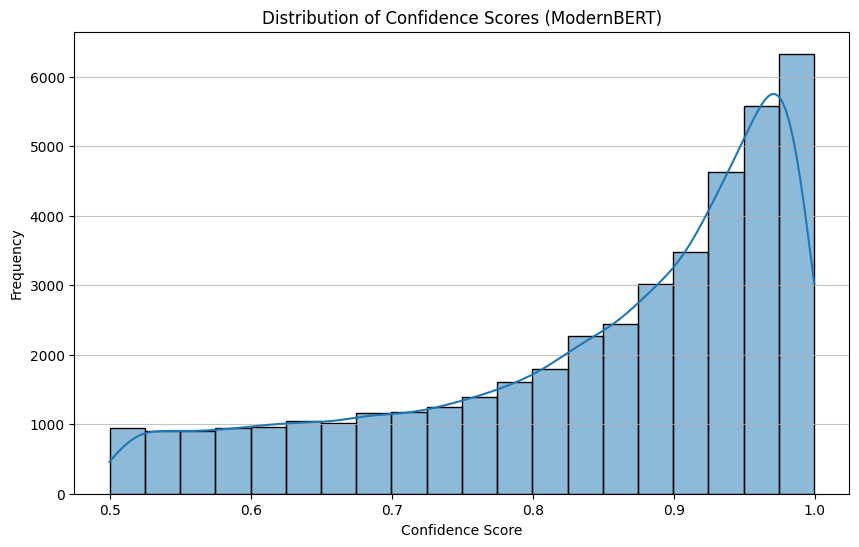

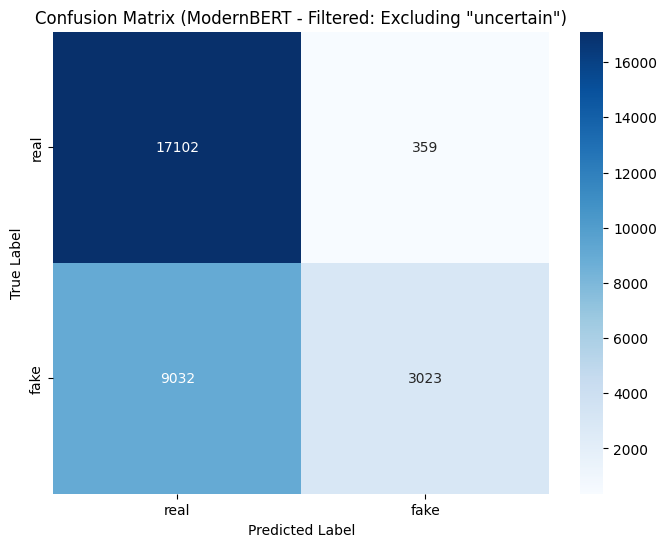


Confusion Matrix (ModernBERT):


array([[17102,   359],
       [ 9032,  3023]])

In [36]:
# prompt: confidence curve for  modernbert

# === Config for ModernBERT ===
SAVE_PATH_MODERNBERT = "/content/drive/MyDrive/DatasetForColab/Zeroshot1/Modernbert_maxscore_results(0.8).json"
THRESHOLD_MODERNBERT = 0.8

# === Load JSON (array format) for ModernBERT ===
with open(SAVE_PATH_MODERNBERT, "r") as f:
    saved_results_modernbert = json.load(f)

# === Convert to DataFrame for ModernBERT ===
df_results_modernbert = pd.DataFrame(saved_results_modernbert)

# === Label Mapping for ModernBERT ===
label_mapping_modernbert = {
    "This news is real and based on facts.": "real",
    "This news is fake and contains misinformation.": "fake"
}
df_results_modernbert['predicted_label_mapped'] = df_results_modernbert['predicted_label'].map(label_mapping_modernbert).fillna('uncertain')

# === Filter out uncertain predictions for ModernBERT ===
df_filtered_modernbert = df_results_modernbert[df_results_modernbert['predicted_label_mapped'] != 'uncertain'].copy()
df_filtered_modernbert['is_correct'] = (df_filtered_modernbert['true_label'] == df_filtered_modernbert['predicted_label_mapped'])

# === Bin confidence scores for ModernBERT ===
bins = np.arange(0, 1.01, 0.1)
bin_labels = [f'{b:.1f}-{b + 0.1:.1f}' for b in bins[:-1]]
df_filtered_modernbert['confidence_bin'] = pd.cut(df_filtered_modernbert['confidence'], bins=bins, right=False, labels=bin_labels)

# === Accuracy per bin for ModernBERT ===
confidence_accuracy_modernbert = df_filtered_modernbert.groupby('confidence_bin', observed=True)['is_correct'].mean().reset_index()
confidence_accuracy_modernbert = confidence_accuracy_modernbert.rename(columns={'is_correct': 'accuracy'})

# === Count per bin for ModernBERT ===
bin_counts_modernbert = df_filtered_modernbert.groupby('confidence_bin', observed=True).size().reset_index(name='count')

# === Merge accuracy + counts for ModernBERT ===
confidence_data_modernbert = pd.merge(confidence_accuracy_modernbert, bin_counts_modernbert, on='confidence_bin')

# === Cumulative calculations for ModernBERT ===
confidence_data_modernbert['bin_midpoint'] = confidence_data_modernbert['confidence_bin'].apply(
    lambda x: float(x.split('-')[0]) + 0.05 if pd.notna(x) else np.nan
)
confidence_data_modernbert = confidence_data_modernbert.sort_values('bin_midpoint').reset_index(drop=True)
confidence_data_modernbert['cumulative_count'] = confidence_data_modernbert['count'].cumsum()
confidence_data_modernbert['cumulative_correct'] = (confidence_data_modernbert['accuracy'] * confidence_data_modernbert['count']).cumsum()
confidence_data_modernbert['cumulative_accuracy'] = confidence_data_modernbert['cumulative_correct'] / confidence_data_modernbert['cumulative_count']

# === Clean up and drop bins with no accuracy for ModernBERT ===
confidence_data_modernbert = confidence_data_modernbert.drop(columns=['bin_midpoint'])
confidence_data_modernbert = confidence_data_modernbert.dropna(subset=['cumulative_accuracy'])

# === Plot Confidence Curve for ModernBERT ===
plt.figure(figsize=(10, 6))
plt.plot(confidence_data_modernbert['confidence_bin'], confidence_data_modernbert['cumulative_accuracy'],
         marker='o', linestyle='-', label='Cumulative Accuracy (ModernBERT)')

# Horizontal line for overall accuracy for ModernBERT
overall_accuracy_modernbert = df_filtered_modernbert['is_correct'].mean()
plt.axhline(y=overall_accuracy_modernbert, color='purple', linestyle='--', label='Overall Accuracy (ModernBERT)')

# Vertical line for threshold for ModernBERT
threshold_bin_modernbert = f'{THRESHOLD_MODERNBERT:.1f}-{THRESHOLD_MODERNBERT + 0.1:.1f}'
if threshold_bin_modernbert in confidence_data_modernbert['confidence_bin'].values:
    plt.axvline(x=threshold_bin_modernbert, color='orange', linestyle='--', label=f'Threshold ({THRESHOLD_MODERNBERT:.1f})')


# === Plot formatting ===
plt.xlabel('Confidence Bin')
plt.ylabel('Accuracy')
plt.title('Confidence Curve (ModernBERT)')
plt.grid(True)
plt.xticks(rotation=45, ha='right')
plt.ylim(0, 1.1)
plt.legend(loc='lower right')
plt.tight_layout()
plt.savefig('confidence_curve_modernbert.png')
plt.show()

# === Print table ===
print("\nConfidence Data (ModernBERT):")
print(confidence_data_modernbert[['confidence_bin', 'count', 'accuracy', 'cumulative_count', 'cumulative_accuracy']])

# Plotting the distribution of confidence scores for the ModernBERT model
plt.figure(figsize=(10, 6))
sns.histplot(df_results_modernbert['confidence'], bins=20, kde=True)
plt.title('Distribution of Confidence Scores (ModernBERT)')
plt.xlabel('Confidence Score')
plt.ylabel('Frequency')
plt.grid(axis='y', alpha=0.75)
plt.savefig('confidence_score_distribution_modernbert.png')
plt.show()

# Convert results to DataFrame
df_results_modernbert = pd.DataFrame(saved_results_modernbert)

# Map predicted labels to 'real', 'fake', or 'uncertain'
label_mapping = {
    "This news is real and based on facts.": "real",
    "This news is fake and contains misinformation.": "fake"
}
df_results_modernbert['predicted_label_mapped'] = df_results_modernbert['predicted_label'].map(label_mapping).fillna('uncertain')

# Filter out 'uncertain' predictions
df_filtered_modernbert = df_results_modernbert[df_results_modernbert['predicted_label_mapped'] != 'uncertain'].copy()
df_filtered_modernbert['is_correct'] = (df_filtered_modernbert['true_label'] == df_filtered_modernbert['predicted_label_mapped'])


# Get true and predicted labels from the filtered DataFrame for ModernBERT
true_labels_filtered_modernbert = df_filtered_modernbert['true_label']
predicted_labels_filtered_modernbert = df_filtered_modernbert['predicted_label_mapped']

# Generate the confusion matrix for ModernBERT
cm_modernbert = confusion_matrix(true_labels_filtered_modernbert, predicted_labels_filtered_modernbert, labels=['real', 'fake'])

# Plot the confusion matrix for ModernBERT
plt.figure(figsize=(8, 6))
sns.heatmap(cm_modernbert, annot=True, fmt='d', cmap='Blues', xticklabels=['real', 'fake'], yticklabels=['real', 'fake'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix (ModernBERT - Filtered: Excluding "uncertain")')
plt.savefig('confusion_matrix_filtered_modernbert.png')
plt.show()

# Optional: Calculate and print confusion matrix values for ModernBERT
print("\nConfusion Matrix (ModernBERT):")
cm_modernbert


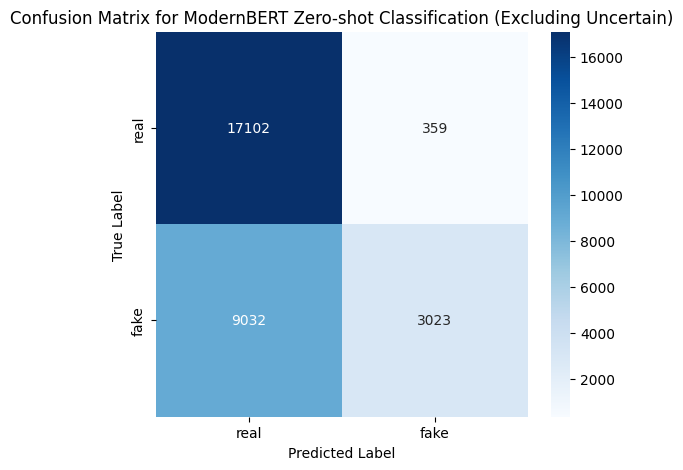

✅ Accuracy (excluding uncertain): 0.6818
ℹ️ Number of uncertain predictions: 13316
Total predictions: 42832
Predictions used for evaluation: 29516


In [37]:
# Filter out uncertain predictions
filtered_results = [
    result for result in saved_results if result["predicted_label"] != "uncertain"
]

# Extract true and predicted labels for evaluation
true_labels_eval = [result["true_label"] for result in filtered_results]
# Map predicted labels from sentences back to 'real'/'fake'
predicted_labels_eval = [
    'real' if result["predicted_label"] == LABELS[0] else 'fake'
    for result in filtered_results
]

# Define labels for the confusion matrix
labels = ['real', 'fake']

# Compute Confusion Matrix
cm = confusion_matrix(true_labels_eval, predicted_labels_eval, labels=labels)

# Display the Confusion Matrix
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=labels, yticklabels=labels)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix for ModernBERT Zero-shot Classification (Excluding Uncertain)")
plt.show()

# Calculate Accuracy on filtered results
if filtered_results:
    accuracy = accuracy_score(true_labels_eval, predicted_labels_eval)
    print(f"✅ Accuracy (excluding uncertain): {accuracy:.4f}")
else:
    print("❌ No predictions available after filtering uncertain results.")

# Optional: Calculate and print other metrics (Precision, Recall, F1)
# precision = precision_score(true_labels_eval, predicted_labels_eval, pos_label='real')
# recall = recall_score(true_labels_eval, predicted_labels_eval, pos_label='real')
# f1 = f1_score(true_labels_eval, predicted_labels_eval, pos_label='real')
# print(f"Precision (excluding uncertain): {precision:.4f}")
# print(f"Recall (excluding uncertain): {recall:.4f}")
# print(f"F1 Score (excluding uncertain): {f1:.4f}")

# Report the number of uncertain predictions
num_uncertain = len([
    result for result in saved_results if result["predicted_label"] == "uncertain"
])
print(f"ℹ️ Number of uncertain predictions: {num_uncertain}")
print(f"Total predictions: {len(saved_results)}")
print(f"Predictions used for evaluation: {len(filtered_results)}")


##cross-encoder/nli-deberta-v3-base

In [38]:
# === Config ===
MODEL_NAME = "cross-encoder/nli-deberta-v3-base"
SAVE_PATH = "/content/drive/MyDrive/DatasetForColab/Zeroshot1/ce_deberta_maxscore_results(0.8).json"
THRESHOLD = 0.8
LABELS = [
    "This news is real and based on facts.",
    "This news is fake and contains misinformation."
]

# === Load model and tokenizer ===
classifier = pipeline("zero-shot-classification", model=MODEL_NAME, device=0)
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)

# === Load your dataset ===
df_balanced = df_balanced.copy()
texts = df_balanced["clean_text"].tolist()
true_labels = df_balanced["label"].tolist()

# === Chunking function ===
def chunk_text(text, tokenizer, max_tokens=512):
    tokens = tokenizer.tokenize(text)
    chunks = []
    for i in range(0, len(tokens), max_tokens):
        chunk = tokenizer.convert_tokens_to_string(tokens[i:i + max_tokens])
        chunks.append(chunk)
    return chunks

# === Classifier function ===
def classify_with_max_chunk(text, tokenizer, classifier, labels, threshold=0.8):
    chunks = chunk_text(text, tokenizer)
    score_dict = defaultdict(float)

    for chunk in chunks:
        result = classifier(chunk, candidate_labels=labels)
        for label, score in zip(result["labels"], result["scores"]):
            score_dict[label] = max(score_dict[label], score)

    final_label = max(score_dict, key=score_dict.get)
    final_score = score_dict[final_label]

    if final_score >= threshold:
        return final_label, final_score
    else:
        return "uncertain", final_score

# === Load saved progress ===
try:
    with open(SAVE_PATH, 'r') as f:
        saved_results = json.load(f)
    print(f"✅ Loaded {len(saved_results)} saved results.")
except FileNotFoundError:
    saved_results = []
    print("🆕 No saved results found. Starting fresh.")

start_index = len(saved_results)

# === Run classification ===
for i in tqdm(range(start_index, len(texts)), desc="Classifying"):
    text = texts[i]
    true_label = true_labels[i]

    predicted_label, score = classify_with_max_chunk(
        text, tokenizer, classifier, LABELS, threshold=THRESHOLD
    )

    saved_results.append({
        "index": i,
        "text": text,
        "true_label": true_label,
        "predicted_label": predicted_label,
        "confidence": round(score, 4)
    })
  # Save every 2000 rows or at the very end
    if (i + 1) % 2000 == 0 or (i + 1) == len(texts):
        with open(SAVE_PATH, 'w') as f:
            json.dump(saved_results, f, indent=2)
        print(f"💾 Saved progress at {i + 1} rows.")

print(f"✅ Classification complete. {len(saved_results)} articles processed and saved to JSON.")



config.json: 0.00B [00:00, ?B/s]

model.safetensors:   0%|          | 0.00/738M [00:00<?, ?B/s]

tokenizer_config.json: 0.00B [00:00, ?B/s]

spm.model:   0%|          | 0.00/2.46M [00:00<?, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

added_tokens.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/301 [00:00<?, ?B/s]

Device set to use cpu


✅ Loaded 42832 saved results.


Classifying: 0it [00:00, ?it/s]

✅ Classification complete. 42832 articles processed and saved to JSON.


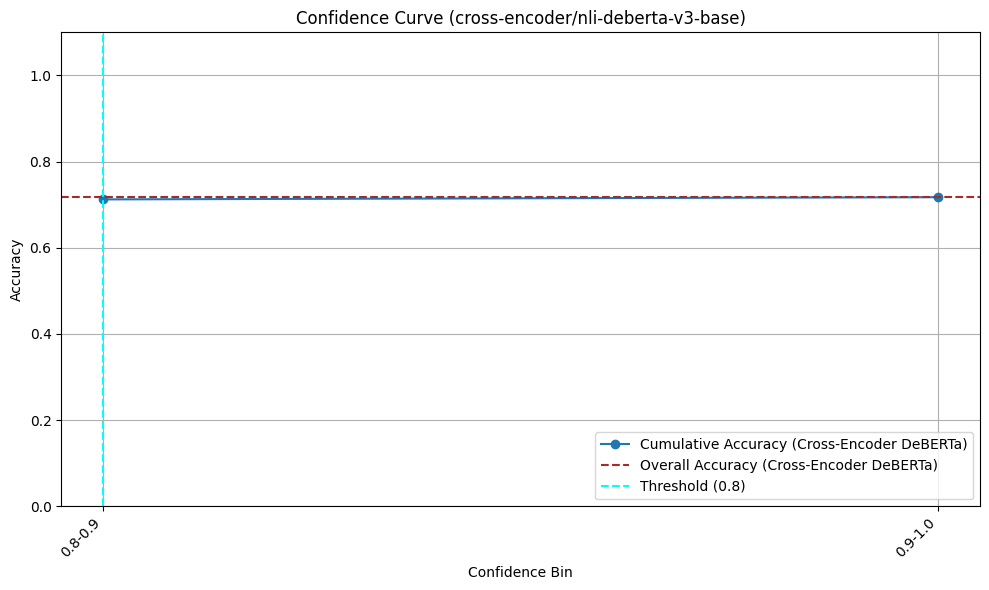


Confidence Data (Cross-Encoder DeBERTa):
  confidence_bin  count  accuracy  cumulative_count  cumulative_accuracy
0        0.8-0.9   5588  0.712241              5588             0.712241
1        0.9-1.0   4730  0.723467             10318             0.717387


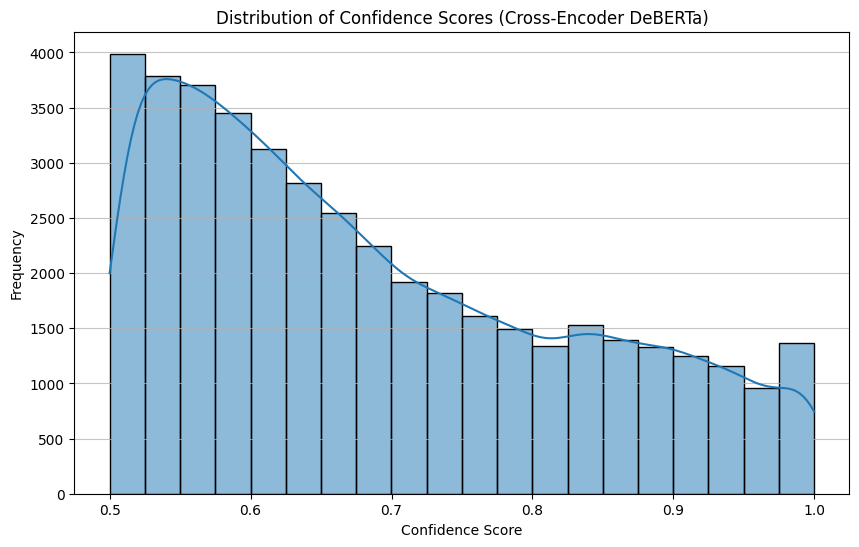

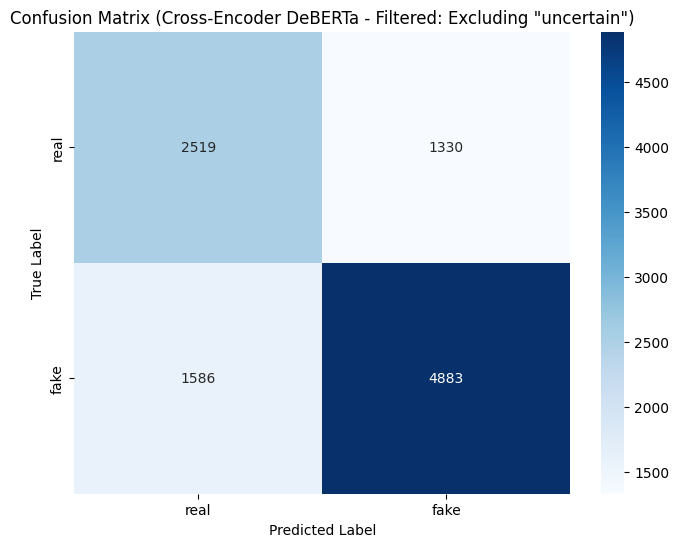


Confusion Matrix (Cross-Encoder DeBERTa):


array([[2519, 1330],
       [1586, 4883]])

In [39]:
# prompt: confidence curve for cross encoder

# === Config for Cross-Encoder DeBERTa ===
SAVE_PATH_CE_DEBERTA = "/content/drive/MyDrive/DatasetForColab/Zeroshot1/ce_deberta_maxscore_results(0.8).json"
THRESHOLD_CE_DEBERTA = 0.8

# === Load JSON (array format) for Cross-Encoder DeBERTa ===
with open(SAVE_PATH_CE_DEBERTA, "r") as f:
    saved_results_ce_deberta = json.load(f)

# === Convert to DataFrame for Cross-Encoder DeBERTa ===
df_results_ce_deberta = pd.DataFrame(saved_results_ce_deberta)

# === Label Mapping for Cross-Encoder DeBERTa ===
label_mapping_ce_deberta = {
    "This news is real and based on facts.": "real",
    "This news is fake and contains misinformation.": "fake"
}
df_results_ce_deberta['predicted_label_mapped'] = df_results_ce_deberta['predicted_label'].map(label_mapping_ce_deberta).fillna('uncertain')

# === Filter out uncertain predictions for Cross-Encoder DeBERTa ===
df_filtered_ce_deberta = df_results_ce_deberta[df_results_ce_deberta['predicted_label_mapped'] != 'uncertain'].copy()
df_filtered_ce_deberta['is_correct'] = (df_filtered_ce_deberta['true_label'] == df_filtered_ce_deberta['predicted_label_mapped'])

# === Bin confidence scores for Cross-Encoder DeBERTa ===
bins = np.arange(0, 1.01, 0.1)
bin_labels = [f'{b:.1f}-{b + 0.1:.1f}' for b in bins[:-1]]
df_filtered_ce_deberta['confidence_bin'] = pd.cut(df_filtered_ce_deberta['confidence'], bins=bins, right=False, labels=bin_labels)

# === Accuracy per bin for Cross-Encoder DeBERTa ===
confidence_accuracy_ce_deberta = df_filtered_ce_deberta.groupby('confidence_bin', observed=True)['is_correct'].mean().reset_index()
confidence_accuracy_ce_deberta = confidence_accuracy_ce_deberta.rename(columns={'is_correct': 'accuracy'})

# === Count per bin for Cross-Encoder DeBERTa ===
bin_counts_ce_deberta = df_filtered_ce_deberta.groupby('confidence_bin', observed=True).size().reset_index(name='count')

# === Merge accuracy + counts for Cross-Encoder DeBERTa ===
confidence_data_ce_deberta = pd.merge(confidence_accuracy_ce_deberta, bin_counts_ce_deberta, on='confidence_bin')

# === Cumulative calculations for Cross-Encoder DeBERTa ===
confidence_data_ce_deberta['bin_midpoint'] = confidence_data_ce_deberta['confidence_bin'].apply(
    lambda x: float(x.split('-')[0]) + 0.05 if pd.notna(x) else np.nan
)
confidence_data_ce_deberta = confidence_data_ce_deberta.sort_values('bin_midpoint').reset_index(drop=True)
confidence_data_ce_deberta['cumulative_count'] = confidence_data_ce_deberta['count'].cumsum()
confidence_data_ce_deberta['cumulative_correct'] = (confidence_data_ce_deberta['accuracy'] * confidence_data_ce_deberta['count']).cumsum()
confidence_data_ce_deberta['cumulative_accuracy'] = confidence_data_ce_deberta['cumulative_correct'] / confidence_data_ce_deberta['cumulative_count']

# === Clean up and drop bins with no accuracy for Cross-Encoder DeBERTa ===
confidence_data_ce_deberta = confidence_data_ce_deberta.drop(columns=['bin_midpoint'])
confidence_data_ce_deberta = confidence_data_ce_deberta.dropna(subset=['cumulative_accuracy'])

# === Plot Confidence Curve for Cross-Encoder DeBERTa ===
plt.figure(figsize=(10, 6))
plt.plot(confidence_data_ce_deberta['confidence_bin'], confidence_data_ce_deberta['cumulative_accuracy'],
         marker='o', linestyle='-', label='Cumulative Accuracy (Cross-Encoder DeBERTa)')

# Horizontal line for overall accuracy for Cross-Encoder DeBERTa
overall_accuracy_ce_deberta = df_filtered_ce_deberta['is_correct'].mean()
plt.axhline(y=overall_accuracy_ce_deberta, color='brown', linestyle='--', label='Overall Accuracy (Cross-Encoder DeBERTa)')

# Vertical line for threshold for Cross-Encoder DeBERTa
threshold_bin_ce_deberta = f'{THRESHOLD_CE_DEBERTA:.1f}-{THRESHOLD_CE_DEBERTA + 0.1:.1f}'
if threshold_bin_ce_deberta in confidence_data_ce_deberta['confidence_bin'].values:
    plt.axvline(x=threshold_bin_ce_deberta, color='cyan', linestyle='--', label=f'Threshold ({THRESHOLD_CE_DEBERTA:.1f})')

# === Plot formatting ===
plt.xlabel('Confidence Bin')
plt.ylabel('Accuracy')
plt.title('Confidence Curve (cross-encoder/nli-deberta-v3-base)')
plt.grid(True)
plt.xticks(rotation=45, ha='right')
plt.ylim(0, 1.1)
plt.legend(loc='lower right')
plt.tight_layout()
plt.savefig('confidence_curve_ce_deberta.png')
plt.show()

# === Print table ===
print("\nConfidence Data (Cross-Encoder DeBERTa):")
print(confidence_data_ce_deberta[['confidence_bin', 'count', 'accuracy', 'cumulative_count', 'cumulative_accuracy']])

# Plotting the distribution of confidence scores for the Cross-Encoder DeBERTa model
plt.figure(figsize=(10, 6))
sns.histplot(df_results_ce_deberta['confidence'], bins=20, kde=True)
plt.title('Distribution of Confidence Scores (Cross-Encoder DeBERTa)')
plt.xlabel('Confidence Score')
plt.ylabel('Frequency')
plt.grid(axis='y', alpha=0.75)
plt.savefig('confidence_score_distribution_ce_deberta.png')
plt.show()

# Convert results to DataFrame
df_results_ce_deberta = pd.DataFrame(saved_results_ce_deberta)

# Map predicted labels to 'real', 'fake', or 'uncertain'
label_mapping = {
    "This news is real and based on facts.": "real",
    "This news is fake and contains misinformation.": "fake"
}
df_results_ce_deberta['predicted_label_mapped'] = df_results_ce_deberta['predicted_label'].map(label_mapping).fillna('uncertain')

# Filter out 'uncertain' predictions
df_filtered_ce_deberta = df_results_ce_deberta[df_results_ce_deberta['predicted_label_mapped'] != 'uncertain'].copy()
df_filtered_ce_deberta['is_correct'] = (df_filtered_ce_deberta['true_label'] == df_filtered_ce_deberta['predicted_label_mapped'])

# Get true and predicted labels from the filtered DataFrame for Cross-Encoder DeBERTa
true_labels_filtered_ce_deberta = df_filtered_ce_deberta['true_label']
predicted_labels_filtered_ce_deberta = df_filtered_ce_deberta['predicted_label_mapped']

# Generate the confusion matrix for Cross-Encoder DeBERTa
cm_ce_deberta = confusion_matrix(true_labels_filtered_ce_deberta, predicted_labels_filtered_ce_deberta, labels=['real', 'fake'])

# Plot the confusion matrix for Cross-Encoder DeBERTa
plt.figure(figsize=(8, 6))
sns.heatmap(cm_ce_deberta, annot=True, fmt='d', cmap='Blues', xticklabels=['real', 'fake'], yticklabels=['real', 'fake'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix (Cross-Encoder DeBERTa - Filtered: Excluding "uncertain")')
plt.savefig('confusion_matrix_filtered_ce_deberta.png')
plt.show()

# Optional: Calculate and print confusion matrix values for Cross-Encoder DeBERTa
print("\nConfusion Matrix (Cross-Encoder DeBERTa):")
cm_ce_deberta

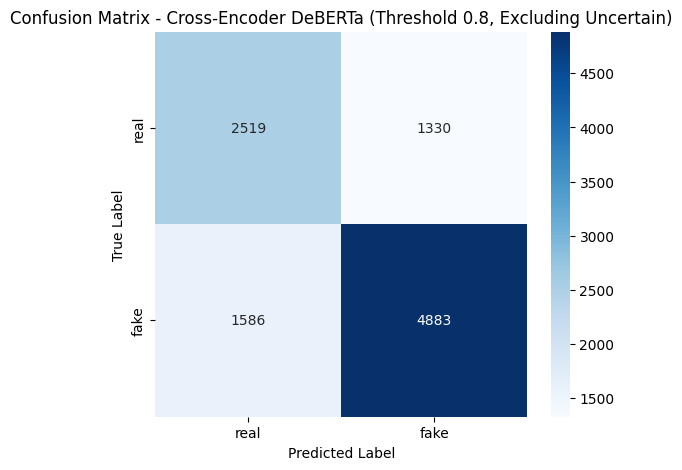

✅ Accuracy (excluding uncertain): 0.7174


In [40]:
# === Load saved results ===
results_path = "/content/drive/MyDrive/DatasetForColab/Zeroshot1/ce_deberta_maxscore_results(0.8).json"

with open(results_path, "r") as f:
    saved_results = json.load(f)

# === Define candidate labels (must match what was used during inference) ===
LABELS = [
    "This news is real and based on facts.",
    "This news is fake and contains misinformation."
]

# === Filter out uncertain predictions ===
filtered_results = [
    result for result in saved_results if result["predicted_label"] != "uncertain"
]

# === Check and evaluate ===
if len(filtered_results) == 0:
    print("❌ No decided predictions (above threshold) to evaluate.")
else:
    # Extract ground-truth and predicted labels
    true_labels_eval = [result["true_label"] for result in filtered_results]
    predicted_labels_eval = [
        'real' if result["predicted_label"] == LABELS[0] else 'fake'
        for result in filtered_results
    ]

    # Define fixed label order
    labels = ['real', 'fake']

    # Compute and show confusion matrix
    cm = confusion_matrix(true_labels_eval, predicted_labels_eval, labels=labels)

    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=labels, yticklabels=labels)
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.title("Confusion Matrix - Cross-Encoder DeBERTa (Threshold 0.8, Excluding Uncertain)")
    plt.show()

    # Calculate and print accuracy
    accuracy = accuracy_score(true_labels_eval, predicted_labels_eval)
    print(f"✅ Accuracy (excluding uncertain): {accuracy:.4f}")

# === Report counts ===
num_uncertain = len([
    result for result in saved_results if result["predicted_label"] == "uncertain"
])


## Evaluation and compare before ensemble


In [41]:
!pip install kaleido==0.2.1

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.9/79.9 MB 12.4 MB/s eta 0:00:00
  Attempting uninstall: kaleido
    Found existing installation: kaleido 1.0.0
    Uninstalling kaleido-1.0.0:
      Successfully uninstalled kaleido-1.0.0



🔍 Metrics Table:
             Accuracy  Precision    Recall  F1-Score  Uncertain
DeBERTa     0.769178   0.799223  0.769178  0.726354   0.593995
BART        0.667029   0.738462  0.667029  0.614762   0.442286
ModernBERT  0.681834   0.752195  0.681834  0.624104   0.310889
CE-DeBERTa  0.717387   0.721662  0.717387  0.719083   0.759105


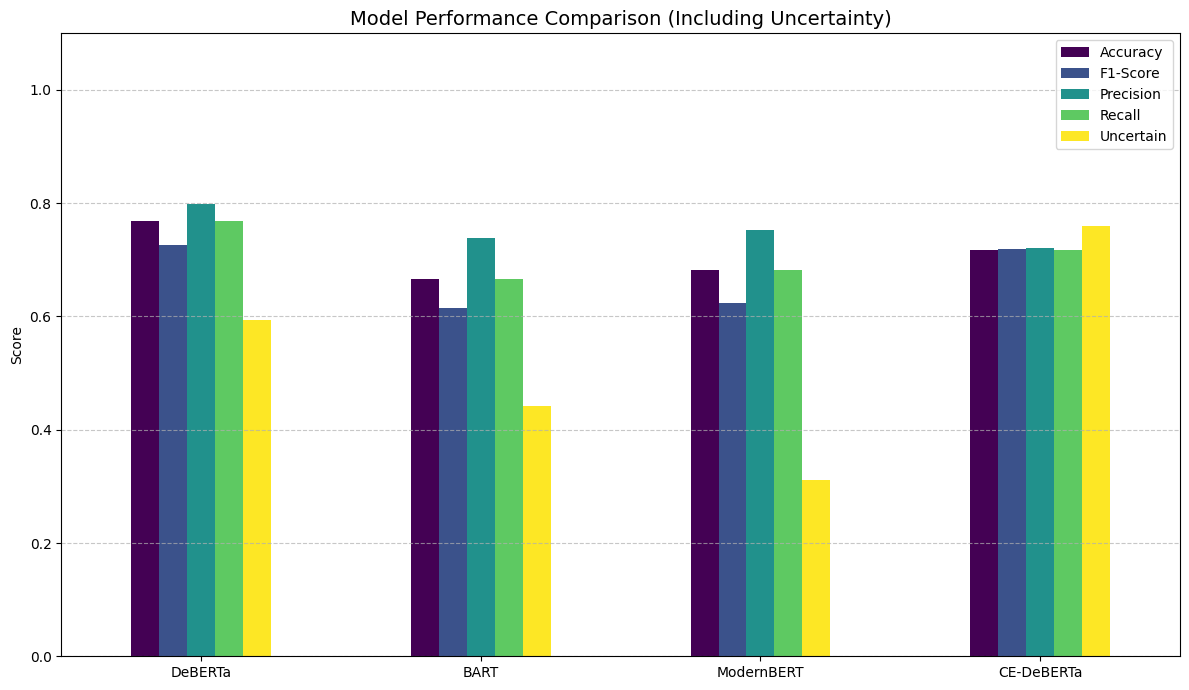

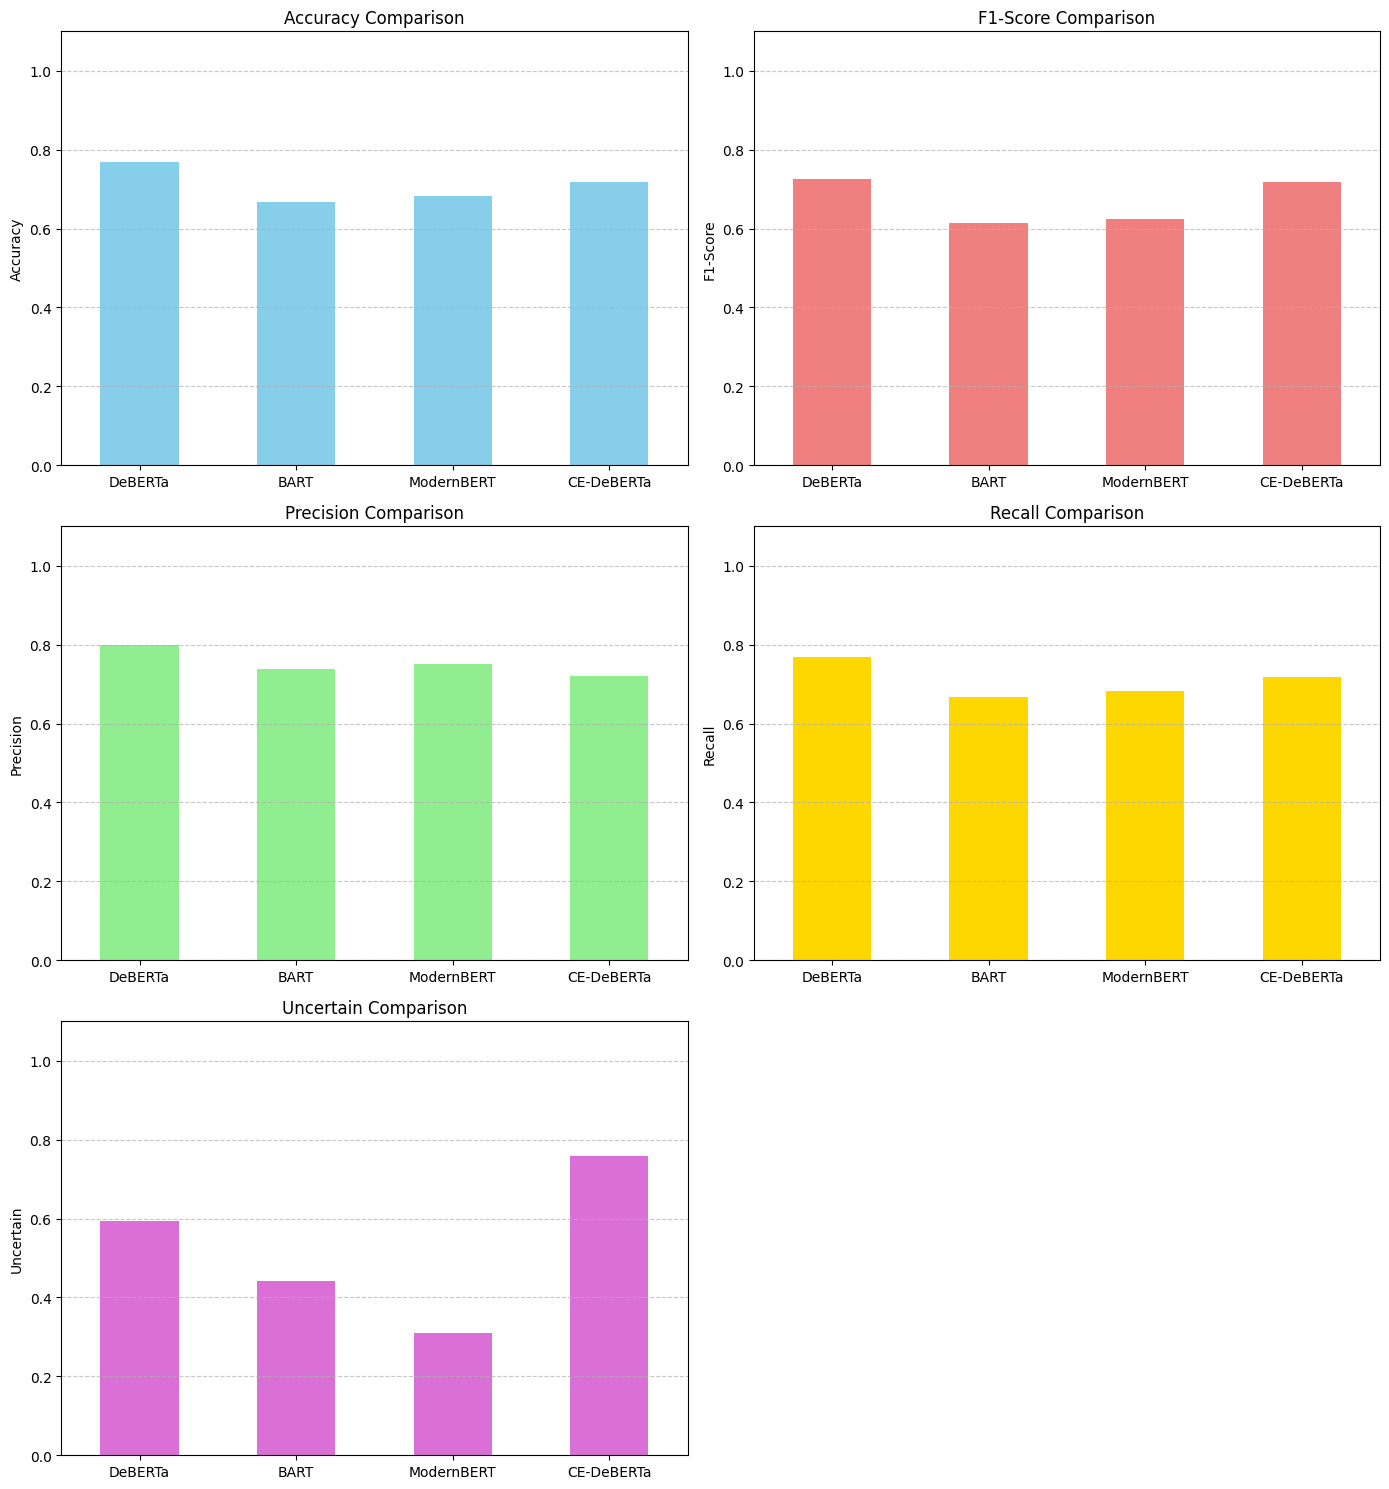

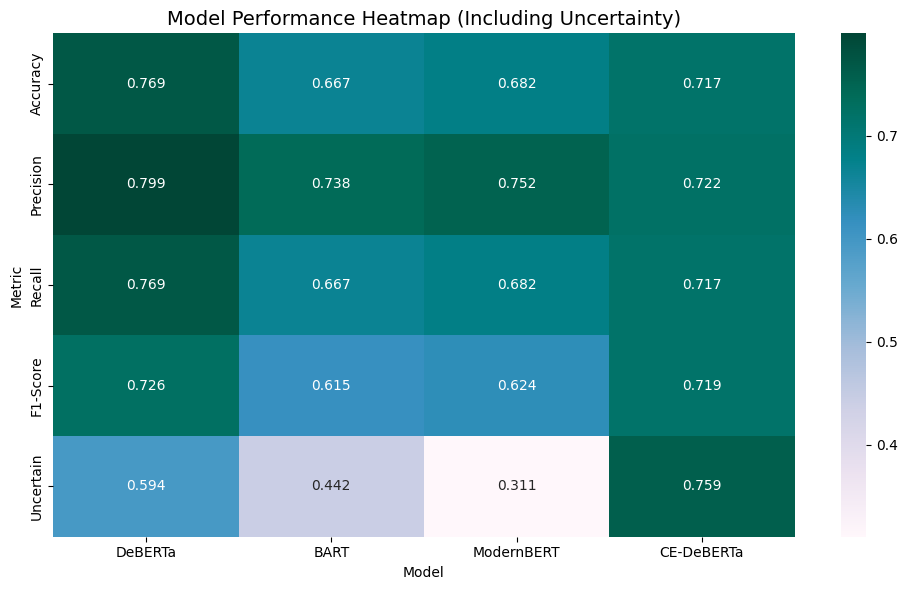

In [42]:
import json
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

# === Load and Calculate Metrics ===
def calculate_metrics(results_path, threshold=0.8, labels=["This news is real and based on facts.", "This news is fake and contains misinformation."]):
    with open(results_path, "r") as f:
        saved_results = json.load(f)

    filtered_results = [r for r in saved_results if r["predicted_label"] != "uncertain"]
    num_uncertain = len(saved_results) - len(filtered_results)
    total_predictions = len(saved_results)

    if not filtered_results:
        return None, None, None, None, None, num_uncertain, total_predictions

    true_labels_eval = [r["true_label"] for r in filtered_results]
    label_map = {labels[0]: 'real', labels[1]: 'fake'}
    predicted_labels_eval = [label_map.get(r["predicted_label"], 'uncertain') for r in filtered_results]

    # Filter again if any 'uncertain' slipped through
    true_labels_eval = [t for i, t in enumerate(true_labels_eval) if predicted_labels_eval[i] in ['real', 'fake']]
    predicted_labels_eval = [p for p in predicted_labels_eval if p in ['real', 'fake']]

    if not true_labels_eval or len(true_labels_eval) != len(predicted_labels_eval):
        return None, None, None, None, None, num_uncertain, total_predictions

    accuracy = accuracy_score(true_labels_eval, predicted_labels_eval)
    precision = precision_score(true_labels_eval, predicted_labels_eval, average='weighted', zero_division=0)
    recall = recall_score(true_labels_eval, predicted_labels_eval, average='weighted', zero_division=0)
    f1 = f1_score(true_labels_eval, predicted_labels_eval, average='weighted', zero_division=0)
    return accuracy, precision, recall, f1, None, num_uncertain, total_predictions


# === Model Paths ===
paths = {
    "DeBERTa": "/content/drive/MyDrive/DatasetForColab/Zeroshot1/Deberta_maxscore_results(0.8).json",
    "BART": "/content/drive/MyDrive/DatasetForColab/Zeroshot1/bart_maxscore_results(0.8).json",
    "ModernBERT": "/content/drive/MyDrive/DatasetForColab/Zeroshot1/Modernbert_maxscore_results(0.8).json",
    "CE-DeBERTa": "/content/drive/MyDrive/DatasetForColab/Zeroshot1/ce_deberta_maxscore_results(0.8).json"
}

metrics = {}

for model_name, path in paths.items():
    acc, prec, rec, f1_sc, _, uncertain, total = calculate_metrics(path)
    if acc is not None:
        metrics[model_name] = {
            "Accuracy": acc,
            "Precision": prec,
            "Recall": rec,
            "F1-Score": f1_sc,
            "Uncertain": uncertain / total if total > 0 else 0
        }

# === Convert to DataFrame ===
metrics_df = pd.DataFrame(metrics).T
print("\n🔍 Metrics Table:\n", metrics_df)

# === 1. Combined Bar Chart ===
metrics_df[['Accuracy', 'F1-Score', 'Precision', 'Recall', 'Uncertain']].plot(
    kind='bar',
    figsize=(12, 7),
    colormap='viridis'
)
plt.title('Model Performance Comparison (Including Uncertainty)', fontsize=14)
plt.ylabel('Score')
plt.ylim(0, 1.1)
plt.xticks(rotation=0)
plt.legend(loc='upper right')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.savefig('model_performance_bar_chart_with_uncertainty.png')
plt.show()

# === 2. Individual Bar Charts ===
fig, axes = plt.subplots(3, 2, figsize=(14, 15))
axes = axes.flatten()
metrics_list = ['Accuracy', 'F1-Score', 'Precision', 'Recall', 'Uncertain']
colors = ['skyblue', 'lightcoral', 'lightgreen', 'gold', 'orchid']

for i, metric in enumerate(metrics_list):
    metrics_df[metric].plot(kind='bar', ax=axes[i], color=colors[i])
    axes[i].set_title(f'{metric} Comparison')
    axes[i].set_ylabel(metric)
    axes[i].set_ylim(0, 1.1)
    axes[i].tick_params(axis='x', rotation=0)
    axes[i].grid(axis='y', linestyle='--', alpha=0.7)

# Hide empty 6th subplot
if len(axes) > len(metrics_list):
    for j in range(len(metrics_list), len(axes)):
        axes[j].axis('off')

plt.tight_layout()
plt.savefig('model_individual_metrics_bar_charts_with_uncertainty.png')
plt.show()

# === 3. Radar Chart ===
categories = ['Accuracy', 'Precision', 'Recall', 'F1-Score', 'Uncertain']
fig = go.Figure()
desired_order = ["CE-DeBERTa", "DeBERTa", "BART", "ModernBERT"]

for model in desired_order:
    values = [metrics[model].get(c, 0) for c in categories]
    values += values[:1]
    fig.add_trace(go.Scatterpolar(
        r=values,
        theta=categories + categories[:1],
        fill='toself',
        name=model
    ))

fig.update_layout(
    polar=dict(radialaxis=dict(visible=True, range=[0, 1])),
    showlegend=True,
    title='Model Performance Radar Chart (Including Uncertainty)',
    height=700,
    width=900
)
fig.write_image("model_performance_radar_chart_with_uncertainty.png")  # requires kaleido
fig.show()

# === 4. Heatmap ===
plt.figure(figsize=(10, 6))
sns.heatmap(metrics_df[['Accuracy', 'Precision', 'Recall', 'F1-Score', 'Uncertain']].T,
            annot=True, fmt=".3f", cmap="PuBuGn")  # dreamy blue-green
plt.title('Model Performance Heatmap (Including Uncertainty)', fontsize=14)
plt.ylabel('Metric')
plt.xlabel('Model')
plt.tight_layout()
plt.savefig('model_performance_heatmap_with_uncertainty.png')
plt.show()



📊 Model Performance Scores:
             Accuracy  Precision    Recall  F1-Score  Uncertain  Certainty  \
DeBERTa     0.769178   0.799223  0.769178  0.726354   0.593995   0.406005   
BART        0.667029   0.738462  0.667029  0.614762   0.442286   0.557714   
ModernBERT  0.681834   0.752195  0.681834  0.624104   0.310889   0.689111   
CE-DeBERTa  0.717387   0.721662  0.717387  0.719083   0.759105   0.240895   

            Performance_Score  
DeBERTa              0.693987  
BART                 0.648999  
ModernBERT           0.685815  
CE-DeBERTa           0.623283  


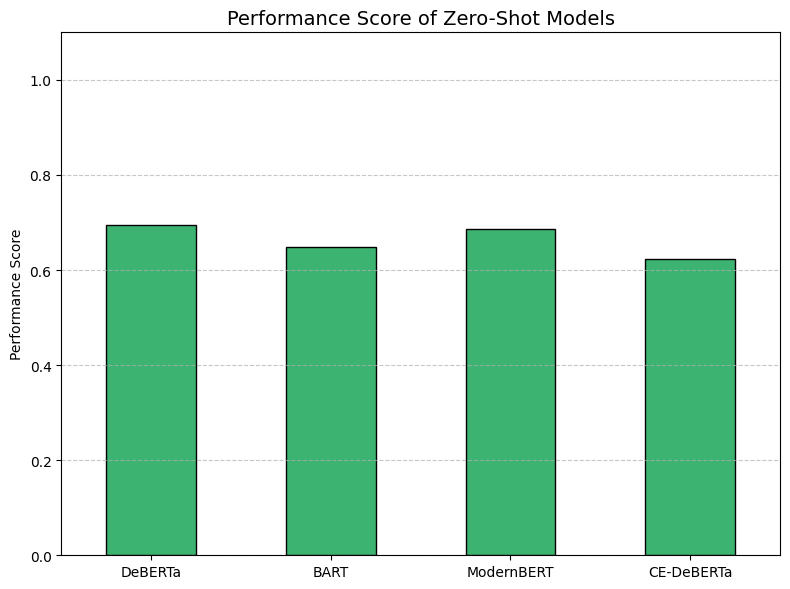

In [43]:
# === Add Certainty and Performance Score ===
metrics_df['Certainty'] = 1 - metrics_df['Uncertain']
metrics_df['Performance_Score'] = metrics_df[
    ['Accuracy', 'Precision', 'Recall', 'F1-Score', 'Certainty']
].mean(axis=1)

# Optional: Print table
print("\n📊 Model Performance Scores:\n", metrics_df[['Accuracy', 'Precision', 'Recall', 'F1-Score', 'Uncertain', 'Certainty', 'Performance_Score']])
# === 5. Performance Score Bar Chart ===
plt.figure(figsize=(8, 6))
metrics_df['Performance_Score'].plot(
    kind='bar',
    color='mediumseagreen',
    edgecolor='black'
)

plt.title('Performance Score of Zero-Shot Models', fontsize=14)
plt.ylabel('Performance Score')
plt.ylim(0, 1.1)
plt.xticks(rotation=0)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.savefig('model_performance_score_bar_chart.png')
plt.show()


## Applying Ensemble

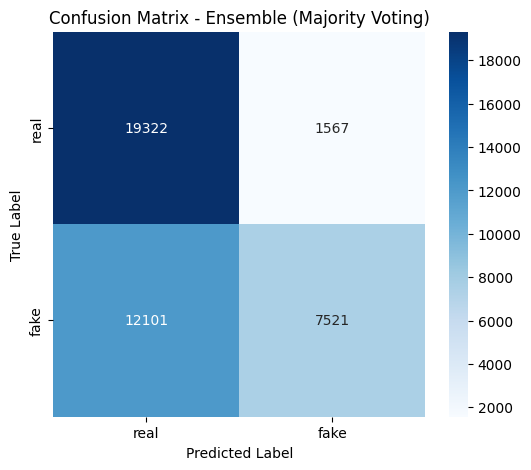

✅ Accuracy (excluding uncertain): 0.6626
Total evaluated predictions: 40511


In [44]:
# === Paths to model outputs ===
paths = {
    "modernbert": "/content/drive/MyDrive/DatasetForColab/Zeroshot1/Modernbert_maxscore_results(0.8).json",
    "bart": "/content/drive/MyDrive/DatasetForColab/Zeroshot1/bart_maxscore_results(0.8).json",
    "deberta": "/content/drive/MyDrive/DatasetForColab/Zeroshot1/Deberta_maxscore_results(0.8).json",
    "crossencoder": "/content/drive/MyDrive/DatasetForColab/Zeroshot1/ce_deberta_maxscore_results1.json"
}

# === Load model predictions ===
all_results = {}
for model_name, path in paths.items():
    with open(path, "r") as f:
        results = json.load(f)
        all_results[model_name] = {r["index"]: r for r in results}

# === Perform majority vote ===
ensemble_results = []
for idx in all_results["modernbert"]:
    votes = []
    true_label = all_results["modernbert"][idx]["true_label"]

    for model in all_results:
        label = all_results[model][idx]["predicted_label"]
        if "real" in label.lower():
            votes.append("real")
        elif "fake" in label.lower():
            votes.append("fake")
        else:
            votes.append("uncertain")

    # Remove uncertain votes
    decided_votes = [v for v in votes if v != "uncertain"]

    if decided_votes:
        final_vote = Counter(decided_votes).most_common(1)[0][0]
        ensemble_results.append({
            "index": idx,
            "true_label": true_label,
            "votes": votes,
            "final_prediction": final_vote
        })

# === Evaluate ensemble ===
true_labels = [r["true_label"] for r in ensemble_results]
predicted_labels = [r["final_prediction"] for r in ensemble_results]

# Confusion Matrix
labels = ["real", "fake"]
cm = confusion_matrix(true_labels, predicted_labels, labels=labels)

plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix - Ensemble (Majority Voting)")
plt.savefig('confusion_matrix_ensemble.png')
plt.show()

# Accuracy
accuracy = accuracy_score(true_labels, predicted_labels)
print(f"✅ Accuracy (excluding uncertain): {accuracy:.4f}")
print(f"Total evaluated predictions: {len(predicted_labels)}")


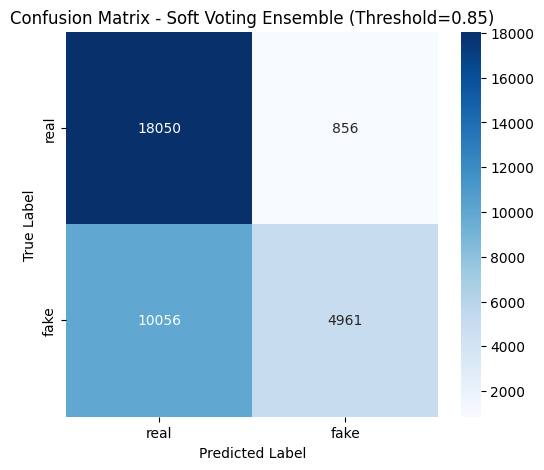

✅ Accuracy (excluding uncertain): 0.6783
Total evaluated predictions: 33923
Total uncertain predictions: 8909


In [45]:
# === Paths to model outputs ===
paths = {
    "modernbert": "/content/drive/MyDrive/DatasetForColab/Zeroshot1/Modernbert_maxscore_results(0.8).json",
    "bart": "/content/drive/MyDrive/DatasetForColab/Zeroshot1/bart_maxscore_results(0.8).json",
    "deberta": "/content/drive/MyDrive/DatasetForColab/Zeroshot1/Deberta_maxscore_results(0.8).json",
    "crossencoder": "/content/drive/MyDrive/DatasetForColab/Zeroshot1/ce_deberta_maxscore_results(0.8).json"
}

THRESHOLD = 0.85  # Minimum soft score for decision

# === Load model predictions ===
all_results = {}
for model_name, path in paths.items():
    with open(path, "r") as f:
        results = json.load(f)
        all_results[model_name] = {r["index"]: r for r in results}

# === Soft voting ensemble ===
ensemble_results = []

for idx in all_results["modernbert"]:  # assume all models share same indexes
    true_label = all_results["modernbert"][idx]["true_label"]

    score_real = 0.0
    score_fake = 0.0
    confidence_count = 0

    for model in all_results:
        result = all_results[model][idx]
        label = result["predicted_label"].lower()
        confidence = result["confidence"]

        if "real" in label:
            score_real += confidence
            confidence_count += 1
        elif "fake" in label:
            score_fake += confidence
            confidence_count += 1
        # "uncertain" labels are ignored

    # Final decision based on max soft score if above threshold
    if max(score_real, score_fake) >= THRESHOLD:
        final_prediction = "real" if score_real > score_fake else "fake"
    else:
        final_prediction = "uncertain"

    ensemble_results.append({
        "index": idx,
        "true_label": true_label,
        "score_real": round(score_real, 4),
        "score_fake": round(score_fake, 4),
        "final_prediction": final_prediction
    })

# === Evaluate ===
filtered = [r for r in ensemble_results if r["final_prediction"] != "uncertain"]
true_labels = [r["true_label"] for r in filtered]
predicted_labels = [r["final_prediction"] for r in filtered]

labels = ["real", "fake"]
cm = confusion_matrix(true_labels, predicted_labels, labels=labels)

plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=labels, yticklabels=labels)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title(f"Confusion Matrix - Soft Voting Ensemble (Threshold={THRESHOLD})")
plt.savefig('confusion_matrix_soft_voting.png')
plt.show()

# === Accuracy ===
accuracy = accuracy_score(true_labels, predicted_labels)
print(f"✅ Accuracy (excluding uncertain): {accuracy:.4f}")
print(f"Total evaluated predictions: {len(predicted_labels)}")
print(f"Total uncertain predictions: {len(ensemble_results) - len(predicted_labels)}")

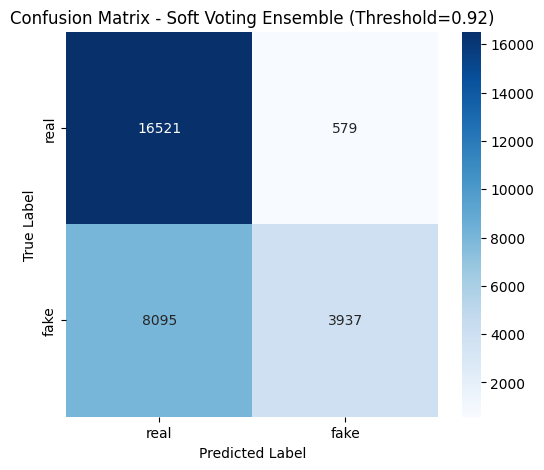

✅ Accuracy (excluding uncertain): 0.7023
🧮 Total evaluated predictions: 29132
🕳️ Total uncertain predictions: 13700


In [46]:
import json
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
from sklearn.metrics import confusion_matrix, accuracy_score

# === Paths to model outputs ===
paths = {
    "modernbert": "/content/drive/MyDrive/DatasetForColab/Zeroshot1/Modernbert_maxscore_results(0.8).json",
    "bart": "/content/drive/MyDrive/DatasetForColab/Zeroshot1/bart_maxscore_results(0.8).json",
    "deberta": "/content/drive/MyDrive/DatasetForColab/Zeroshot1/Deberta_maxscore_results(0.8).json",
    "crossencoder": "/content/drive/MyDrive/DatasetForColab/Zeroshot1/ce_deberta_maxscore_results(0.8).json"
}

THRESHOLD = 0.92  # Confidence threshold for the final decision

# === Load all model results ===
all_results = {}
for model_name, path in paths.items():
    with open(path, "r") as f:
        results = json.load(f)
        all_results[model_name] = {r["index"]: r for r in results}

# === Soft voting ensemble with confidence threshold ===
ensemble_results = []

for idx in all_results["modernbert"]:  # All share same indices
    true_label = all_results["modernbert"][idx]["true_label"]

    score_real = 0.0
    score_fake = 0.0

    for model in all_results:
        result = all_results[model][idx]
        label = result["predicted_label"].lower()
        confidence = result["confidence"]

        if "real" in label:
            score_real += confidence
        elif "fake" in label:
            score_fake += confidence
        # ignore 'uncertain'

    # Apply final thresholding
    if max(score_real, score_fake) >= THRESHOLD:
        final_prediction = "real" if score_real > score_fake else "fake"
    else:
        final_prediction = "uncertain"

    ensemble_results.append({
        "index": idx,
        "true_label": true_label,
        "score_real": round(score_real, 4),
        "score_fake": round(score_fake, 4),
        "final_prediction": final_prediction
    })

# === Evaluation ===
filtered = [r for r in ensemble_results if r["final_prediction"] != "uncertain"]
true_labels = [r["true_label"] for r in filtered]
predicted_labels = [r["final_prediction"] for r in filtered]

labels = ["real", "fake"]
cm = confusion_matrix(true_labels, predicted_labels, labels=labels)

plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=labels, yticklabels=labels)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title(f"Confusion Matrix - Soft Voting Ensemble (Threshold={THRESHOLD})")
plt.savefig('confusion_matrix_soft_voting(.92).png')
plt.show()

# Accuracy
accuracy = accuracy_score(true_labels, predicted_labels)
print(f"✅ Accuracy (excluding uncertain): {accuracy:.4f}")
print(f"🧮 Total evaluated predictions: {len(predicted_labels)}")
print(f"🕳️ Total uncertain predictions: {len(ensemble_results) - len(predicted_labels)}")



Ensemble Performance Metrics:
                         Accuracy  Precision  Recall  F1-Score  Uncertain  \
Majority Vote              0.6697     0.7336  0.6697    0.6290     0.1575   
Soft Vote (Thresh=0.85)    0.6783     0.7355  0.6783    0.6388     0.2080   
Soft Vote (Thresh=0.92)    0.7023     0.7540  0.7023    0.6615     0.3199   

                         Evaluated_Count  Total_Count  Certainty  \
Majority Vote                    36087.0      42832.0     0.8425   
Soft Vote (Thresh=0.85)          33923.0      42832.0     0.7920   
Soft Vote (Thresh=0.92)          29132.0      42832.0     0.6801   

                         Performance_Score  
Majority Vote                       0.7089  
Soft Vote (Thresh=0.85)             0.7046  
Soft Vote (Thresh=0.92)             0.7000  


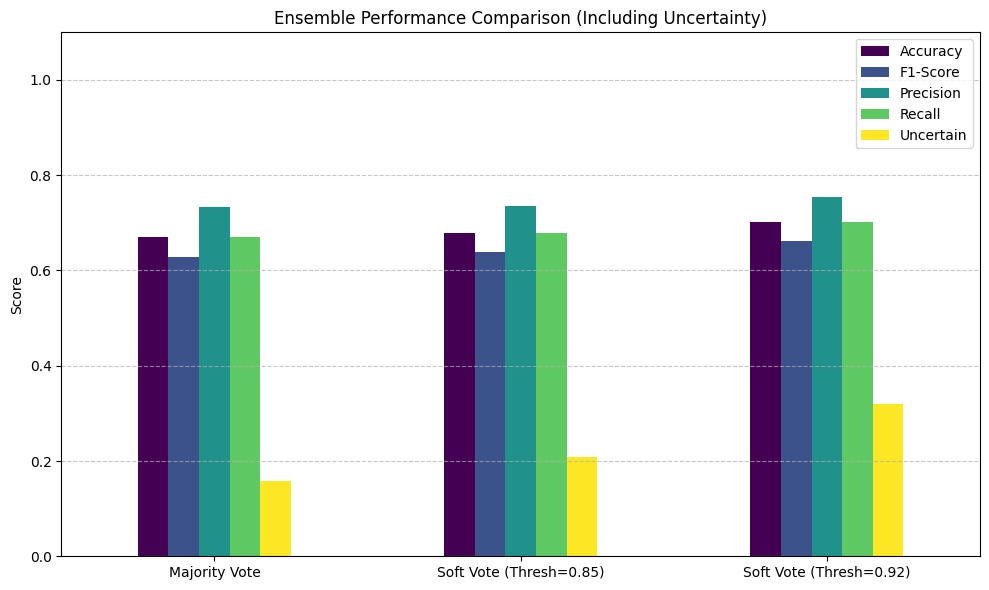

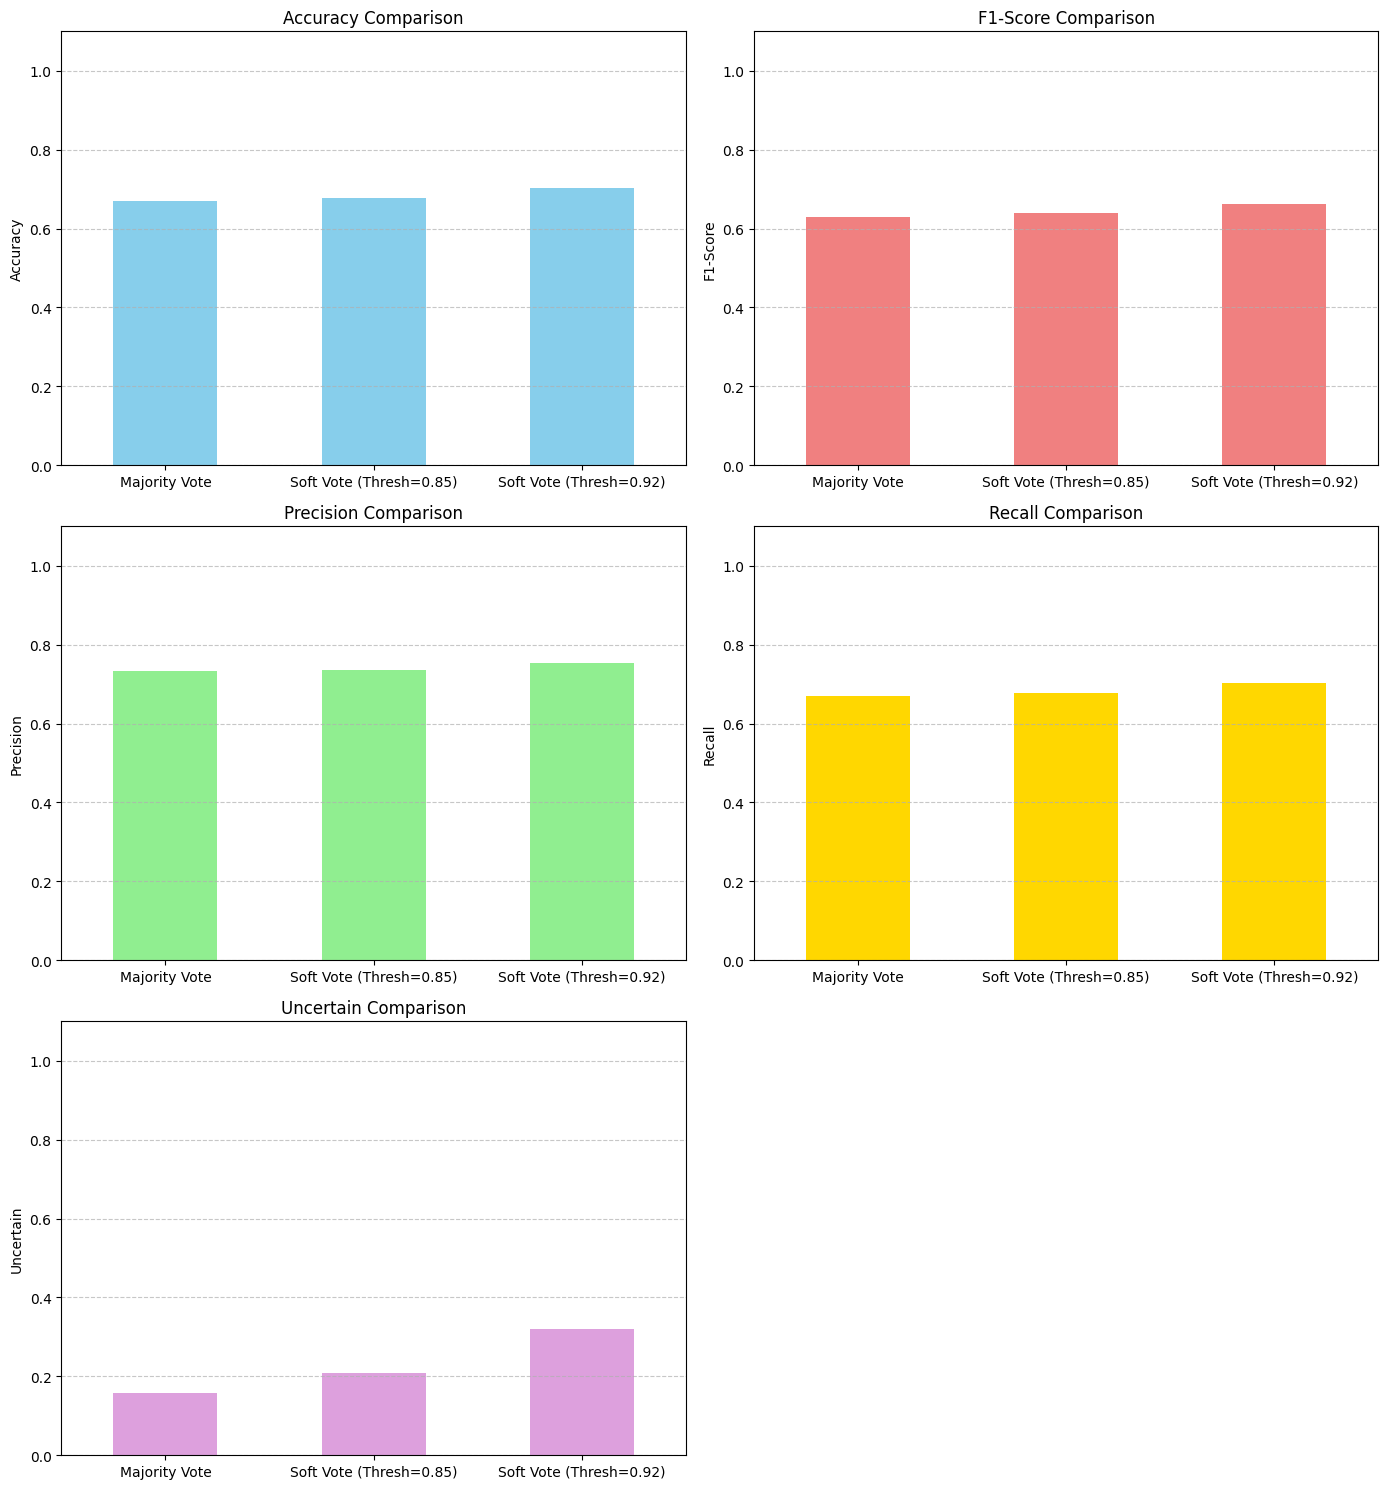

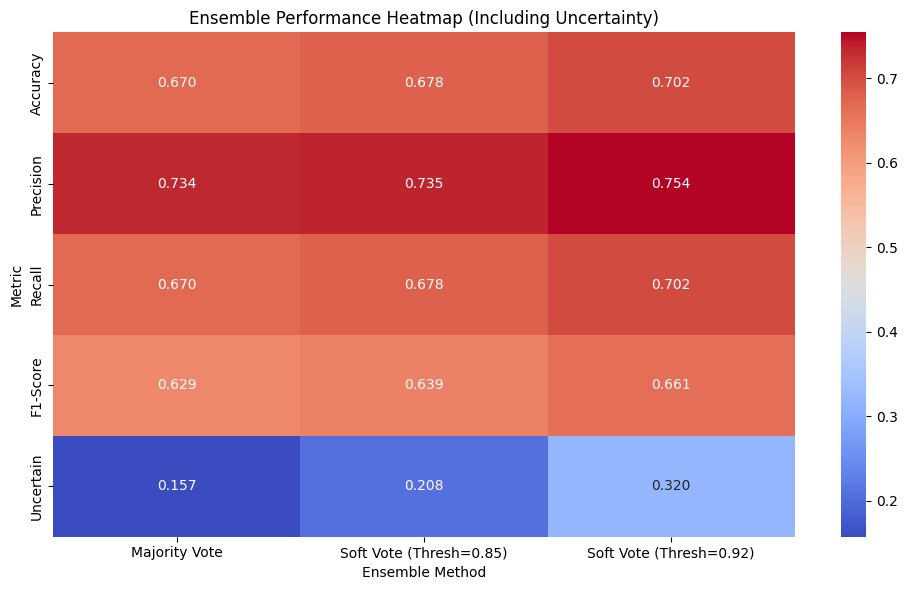

In [47]:
# prompt: # --- Ensemble Metrics Visualization with Uncertainty ---

# === Paths to model outputs ===
paths = {
    "modernbert": "/content/drive/MyDrive/DatasetForColab/Zeroshot1/Modernbert_maxscore_results(0.8).json",
    "bart": "/content/drive/MyDrive/DatasetForColab/Zeroshot1/bart_maxscore_results(0.8).json",
    "deberta": "/content/drive/MyDrive/DatasetForColab/Zeroshot1/Deberta_maxscore_results(0.8).json",
    "crossencoder": "/content/drive/MyDrive/DatasetForColab/Zeroshot1/ce_deberta_maxscore_results(0.8).json"
}

LABELS_MAP = {
    "This news is real and based on facts.": "real",
    "This news is fake and contains misinformation.": "fake"
}

# === Load and process results for all models ===
all_model_data = {}
for model_name, path in paths.items():
    with open(path, "r") as f:
        results = json.load(f)
    all_model_data[model_name] = {
        r["index"]: {
            "true_label": r["true_label"],
            "predicted_label": LABELS_MAP.get(r["predicted_label"], "uncertain"),
            "confidence": r["confidence"]
        }
        for r in results
    }

# Get the set of all unique indices across all models
all_indices = sorted(list(set().union(*[data.keys() for data in all_model_data.values()])))

# === Calculate metrics for each ensemble method ===

def evaluate_ensemble(ensemble_results):
    """Evaluates the ensemble results."""
    filtered_results = [r for r in ensemble_results if r["final_prediction"] != "uncertain"]
    num_uncertain = len(ensemble_results) - len(filtered_results)
    total_predictions = len(ensemble_results)

    if not filtered_results:
        return {
            "Accuracy": 0.0,
            "Precision": 0.0,
            "Recall": 0.0,
            "F1-Score": 0.0,
            "Uncertain": num_uncertain / total_predictions if total_predictions > 0 else 0.0,
            "Evaluated_Count": 0,
            "Total_Count": total_predictions
        }

    true_labels_eval = [r["true_label"] for r in filtered_results]
    predicted_labels_eval = [r["final_prediction"] for r in filtered_results]

    accuracy = accuracy_score(true_labels_eval, predicted_labels_eval)
    precision = precision_score(true_labels_eval, predicted_labels_eval, average='weighted', zero_division=0)
    recall = recall_score(true_labels_eval, predicted_labels_eval, average='weighted', zero_division=0)
    f1 = f1_score(true_labels_eval, predicted_labels_eval, average='weighted', zero_division=0)

    return {
        "Accuracy": accuracy,
        "Precision": precision,
        "Recall": recall,
        "F1-Score": f1,
        "Uncertain": num_uncertain / total_predictions if total_predictions > 0 else 0.0,
        "Evaluated_Count": len(filtered_results),
        "Total_Count": total_predictions
    }

# --- Majority Voting Ensemble ---
majority_vote_results = []
for idx in all_indices:
    votes = []
    true_label = None
    for model_name in all_model_data:
        if idx in all_model_data[model_name]:
            votes.append(all_model_data[model_name][idx]["predicted_label"])
            if true_label is None:
                 true_label = all_model_data[model_name][idx]["true_label"]


    # Remove uncertain votes
    decided_votes = [v for v in votes if v != "uncertain"]

    final_prediction = "uncertain"
    if decided_votes:
         # Handle cases where a model might be missing for an index
        if true_label is None:
           # Find true label from the first model that has this index
           for model_name in all_model_data:
               if idx in all_model_data[model_name]:
                   true_label = all_model_data[model_name][idx]["true_label"]
                   break

        vote_counts = Counter(decided_votes)
        max_count = max(vote_counts.values())
        most_common = [label for label, count in vote_counts.items() if count == max_count]

        if len(most_common) == 1: # Clear majority
             final_prediction = most_common[0]
        else: # Tie, mark as uncertain
            final_prediction = "uncertain"


    majority_vote_results.append({
        "index": idx,
        "true_label": true_label,
        "votes": votes, # Optional: Keep votes for inspection
        "final_prediction": final_prediction
    })

majority_vote_metrics = evaluate_ensemble(majority_vote_results)


# --- Soft Voting Ensemble with Threshold 0.85 ---
soft_vote_085_results = []
threshold_085 = 0.85
for idx in all_indices:
    true_label = None
    score_real = 0.0
    score_fake = 0.0
    model_count_for_index = 0

    for model_name in all_model_data:
        if idx in all_model_data[model_name]:
            result = all_model_data[model_name][idx]
            if true_label is None:
                true_label = result["true_label"]

            label = result["predicted_label"]
            confidence = result["confidence"]
            model_count_for_index += 1 # Count models that actually have a prediction for this index

            if label == "real":
                score_real += confidence
            elif label == "fake":
                score_fake += confidence

    # Normalize scores if needed, or use sum directly with threshold
    # Using sum directly with threshold as implemented previously
    if max(score_real, score_fake) >= threshold_085:
        final_prediction = "real" if score_real > score_fake else "fake"
    else:
        final_prediction = "uncertain"

    soft_vote_085_results.append({
        "index": idx,
        "true_label": true_label,
        "score_real": round(score_real, 4),
        "score_fake": round(score_fake, 4),
        "final_prediction": final_prediction
    })

soft_vote_085_metrics = evaluate_ensemble(soft_vote_085_results)


# --- Soft Voting Ensemble with Threshold 0.92 ---
soft_vote_092_results = []
threshold_092 = 0.92
for idx in all_indices:
    true_label = None
    score_real = 0.0
    score_fake = 0.0
    model_count_for_index = 0

    for model_name in all_model_data:
        if idx in all_model_data[model_name]:
            result = all_model_data[model_name][idx]
            if true_label is None:
                true_label = result["true_label"]

            label = result["predicted_label"]
            confidence = result["confidence"]
            model_count_for_index += 1

            if label == "real":
                score_real += confidence
            elif label == "fake":
                score_fake += confidence

    if max(score_real, score_fake) >= threshold_092:
        final_prediction = "real" if score_real > score_fake else "fake"
    else:
        final_prediction = "uncertain"

    soft_vote_092_results.append({
        "index": idx,
        "true_label": true_label,
        "score_real": round(score_real, 4),
        "score_fake": round(score_fake, 4),
        "final_prediction": final_prediction
    })

soft_vote_092_metrics = evaluate_ensemble(soft_vote_092_results)


# --- Collect all ensemble metrics ---
ensemble_metrics = {
    "Majority Vote": majority_vote_metrics,
    "Soft Vote (Thresh=0.85)": soft_vote_085_metrics,
    "Soft Vote (Thresh=0.92)": soft_vote_092_metrics
}

# Convert to DataFrame
ensemble_metrics_df = pd.DataFrame(ensemble_metrics).T

# Add Certainty and Performance Score
ensemble_metrics_df['Certainty'] = 1 - ensemble_metrics_df['Uncertain']
ensemble_metrics_df['Performance_Score'] = ensemble_metrics_df[['Accuracy', 'Precision', 'Recall', 'F1-Score', 'Certainty']].mean(axis=1)

# === Save Metrics Table ===
ensemble_metrics_df_rounded = ensemble_metrics_df.round(4)
ensemble_metrics_df_rounded.to_csv("ensemble_metrics_with_uncertainty.csv")
print("\nEnsemble Performance Metrics:")
print(ensemble_metrics_df_rounded)

# === 1. Combined Bar Chart ===
metrics_for_bar = ensemble_metrics_df[['Accuracy', 'F1-Score', 'Precision', 'Recall', 'Uncertain']]
metrics_for_bar.plot(kind='bar', figsize=(10, 6), colormap='viridis')
plt.title('Ensemble Performance Comparison (Including Uncertainty)')
plt.ylabel('Score')
plt.ylim(0, 1.1)
plt.xticks(rotation=0)
plt.legend(loc='upper right')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.savefig('ensemble_performance_bar_chart_with_uncertainty.png')
plt.show()

# === 2. Individual Metric Bar Charts ===
fig, axes = plt.subplots(3, 2, figsize=(14, 15))
axes = axes.flatten()
metrics_list = ['Accuracy', 'F1-Score', 'Precision', 'Recall', 'Uncertain']
colors = ['skyblue', 'lightcoral', 'lightgreen', 'gold', 'plum']

for i, metric in enumerate(metrics_list):
    ensemble_metrics_df[metric].plot(kind='bar', ax=axes[i], color=colors[i % len(colors)])
    axes[i].set_title(f'{metric} Comparison')
    axes[i].set_ylabel(metric)
    axes[i].set_ylim(0, 1.1)
    axes[i].tick_params(axis='x', rotation=0)
    axes[i].grid(axis='y', linestyle='--', alpha=0.7)

# Hide unused subplot
if len(axes) > len(metrics_list):
    for j in range(len(metrics_list), len(axes)):
        axes[j].axis('off')

plt.tight_layout()
plt.savefig('ensemble_individual_metrics_bar_charts_with_uncertainty.png')
plt.show()

# === 3. Heatmap ===
plt.figure(figsize=(10, 6))
sns.heatmap(ensemble_metrics_df[['Accuracy', 'Precision', 'Recall', 'F1-Score', 'Uncertain']].T,
            annot=True, fmt=".3f", cmap="coolwarm")
plt.title('Ensemble Performance Heatmap (Including Uncertainty)')
plt.ylabel('Metric')
plt.xlabel('Ensemble Method')
plt.tight_layout()
plt.savefig('ensemble_performance_heatmap_with_uncertainty.png')
plt.show()

# === 4. Radar Chart ===
categories = ['Accuracy', 'Precision', 'Recall', 'F1-Score', 'Uncertain']
fig_radar = go.Figure()

# Sort by overall performance score (lowest to highest)
desired_order = ensemble_metrics_df.sort_values('Performance_Score').index.tolist()

for ensemble_name in desired_order:
    values = [ensemble_metrics_df.loc[ensemble_name][cat] for cat in categories]
    values += values[:1]  # Close the loop
    fig_radar.add_trace(go.Scatterpolar(
        r=values,
        theta=categories + categories[:1],
        fill='toself',
        name=ensemble_name
    ))

fig_radar.update_layout(
    polar=dict(radialaxis=dict(visible=True, range=[0, 1])),
    showlegend=True,
    title='Ensemble Performance Radar Chart (Including Uncertainty)',
    height=700,
    width=900
)

# Save Radar Chart (requires compatible plotly and kaleido versions)
try:
    fig_radar.write_image("ensemble_performance_radar_chart_with_uncertainty.png")
except ValueError as e:
    print("\n⚠️ Radar chart image export failed. Please update plotly and/or kaleido:")
    print(" - pip install -U plotly")
    print(" - or pip install kaleido==0.2.1\n")

fig_radar.show()


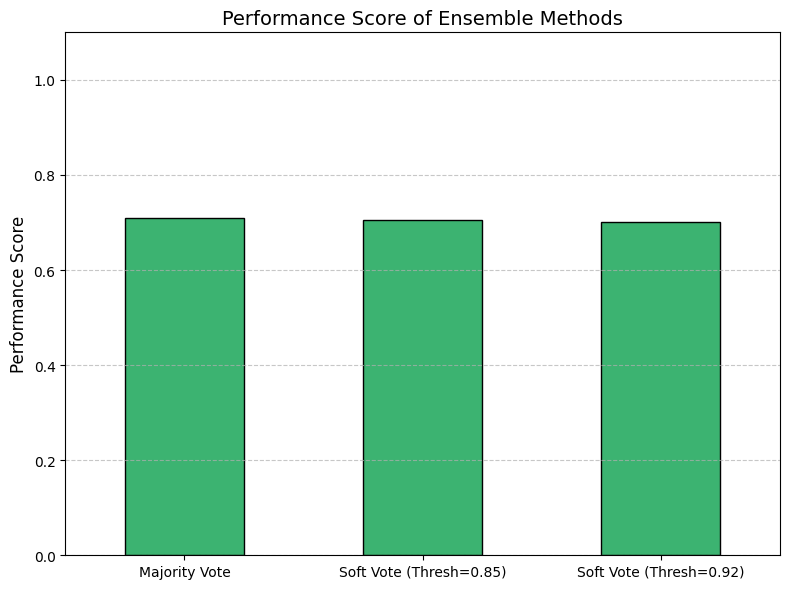

In [48]:
# === Plot Performance Score for Ensemble Methods ===
plt.figure(figsize=(8, 6))
ensemble_metrics_df['Performance_Score'].plot(
    kind='bar',
    color='mediumseagreen',
    edgecolor='black'
)

plt.title('Performance Score of Ensemble Methods', fontsize=14)
plt.ylabel('Performance Score', fontsize=12)
plt.ylim(0, 1.1)
plt.xticks(rotation=0)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.savefig('ensemble_performance_score_bar_chart.png')
plt.show()


In [49]:
# import nbformat
# from google.colab import drive

# # Mount Google Drive if your notebook is saved there
# drive.mount('/content/drive')

# # Replace with your actual notebook path
# notebook_path = '/content/drive/MyDrive/Colab Notebooks/Fake_News_Detection.ipynb'


In [50]:
# import os

# path = '/content/drive/MyDrive/Colab Notebooks/Fake_News_Detection.ipynb'
# print("Exists:", os.path.exists(path))


In [51]:
# import nbformat

# # Path to your notebook
# notebook_path = '/content/drive/MyDrive/Colab Notebooks/Fake_News_Detection.ipynb'

# # Load notebook
# with open(notebook_path, 'r', encoding='utf-8') as f:
#     nb = nbformat.read(f, as_version=nbformat.NO_CONVERT)

# # Remove corrupted widget metadata
# if 'widgets' in nb.metadata:
#     del nb.metadata['widgets']

# # Rebuild clean widget metadata
# nb.metadata['widgets'] = {
#     "state": {},
#     "application/vnd.jupyter.widget-state+json": {
#         "version_major": 2,
#         "version_minor": 0,
#         "state": {}
#     }
# }

# # Save notebook
# with open(notebook_path, 'w', encoding='utf-8') as f:
#     nbformat.write(nb, f)

# print("✅ Widget metadata rebuilt. Now re-run your notebook cells to reinitialize widgets.")
